In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt
import collections
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu


/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
outdir = "/data/qlyu/v1/results"
outdir_fig = "/data/qlyu/projects/v1/figures"

In [3]:
adata = anndata.read("../../data/cheng21_cell_scrna/reorganized/allL23_typegenes_Mar29.h5ad")
adata = adata[adata.obs['cond'].isin(['P28NR', 'P28DR'])]
genes = adata.var.index.values
conds = adata.obs['cond'].values
types = adata.obs['Type'].values
samps = adata.obs['sample'].values
adata

View of AnnData object with n_obs × n_vars = 8748 × 286
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'easitype', 'umap1', 'umap2'
    obsm: 'X_pca'
    layers: 'log10CP10k', 'zlog10CP10k'

In [4]:
adata_raw = anndata.read("../../data/cheng21_cell_scrna/reorganized/all_L23.h5ad")
adata_raw = adata_raw[adata_raw.obs['cond'].isin(['P28NR', 'P28DR'])]
assert np.all(adata_raw.obs.index.values == adata.obs.index.values)
counts = adata_raw.X
allgenes = adata_raw.var.index.values
gi = basicu.get_index_from_array(allgenes, genes)
assert np.all(gi != -1)
counts.shape, gi.shape

((8748, 53801), (286,))

In [5]:
rename = {
    "L2/3_A": "L2/3_A",
    "L2/3_B": "L2/3_B",
    "L2/3_C": "L2/3_C",
    
    "L2/3_1": "L2/3_A",
    "L2/3_2": "L2/3_B",
    "L2/3_3": "L2/3_C",
    
    "L2/3_AB": "L2/3_A",
    "L2/3_BC": "L2/3_C",
}
adata.obs['easitype'] = adata.obs['Type'].apply(lambda x: rename[x])
adata.obs['easisamp'] = adata.obs['sample'].apply(lambda x: x.split('_')[-1].replace("3", "2"))

/tmp/ipykernel_4083281/1273374546.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['easitype'] = adata.obs['Type'].apply(lambda x: rename[x])


In [6]:
zlognorm = adata.layers['zlog10CP10k']
zlognorm.shape

(8748, 286)

In [7]:
# # use those 286 genes
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_sel = df['gene'].astype(str).values
genes_grp = df['P17on'].astype(str).values
assert np.all(genes_sel == adata.var.index.values)

In [8]:
allcolors = sns.color_palette('tab20c', 20)
allcolors

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
 (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
 (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627)]

In [9]:
allcolors2 = sns.color_palette('tab10', 20)
allcolors2

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [10]:
palette = collections.OrderedDict({
#      "P8NR": allcolors[2],
#     "P14NR": allcolors[0],
    
#     "P17NR": allcolors[7],
#     "P21NR": allcolors[6],
    "P28NR": allcolors[5],
    # "P38NR": allcolors[4],
    
    "P28DR": allcolors[14],
    # "P38DR": allcolors[12],
    
    # "P28DL": allcolors[8],
})

cases = np.array(list(palette.keys()))
cases

array(['P28NR', 'P28DR'], dtype='<U5')

In [11]:
palette_types = collections.OrderedDict({
    'L2/3_A': allcolors2[0],
    'L2/3_B': allcolors2[1],
    'L2/3_C': allcolors2[2],
    
    'L2/3_1': allcolors2[0],
    'L2/3_2': allcolors2[1],
    'L2/3_3': allcolors2[2],
    
    'L2/3_AB': allcolors2[0],
    'L2/3_BC': allcolors2[2],
})             

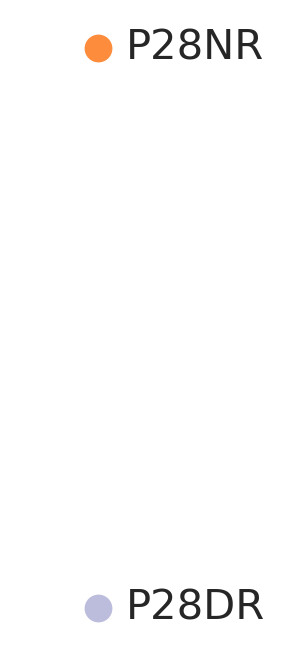

In [12]:
fig, ax = plt.subplots(figsize=(1,4))
for i, (key, item) in enumerate(palette.items()):
    ax.plot(0,     len(palette)-i, 'o', c=item, )
    ax.text(0.02,  len(palette)-i, key, va='center', fontsize=15)
    ax.axis('off')
plt.show()

# heatmap

# give each cell a pseudo-time index

In [13]:
choices1 = sns.color_palette('tab10', 3)
choices1

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

In [14]:
choices2 = sns.color_palette('tab20', 20)
choices2

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [15]:
my_colors = tuple(list(choices1)) #('C0', 'C1', 'C2')
cmap_d1 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

my_colors = tuple(list(choices2[6:8])+list(choices2[14:16]))
cmap_d2 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

ncell, ngene = zlognorm.shape

In [16]:
# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt_df = pd.read_csv(f)
gpt = gpt_df['gene_ptime'].values
geneidx = np.argsort(gpt)

In [17]:
# Use ptime from each sample analysis
dfall = []
for case in cases:
    f = f'../../results/cell_ptime_{case}_L23_Mar28.tsv'
    df = pd.read_csv(f, index_col=0)
    df['case'] = case
    dfall.append(df)
dfall = pd.concat(dfall)
assert len(np.intersect1d(dfall.index.values, adata.obs.index.values)) == len(adata.obs.index.values)
dfall

PC1       PC2       PC3       PC4  \
AAACCCAGTTCTCTCG-1-P28_1a-P28   1.146197  5.233500 -2.200451 -3.930217   
AAACGAAAGCAAGGAA-1-P28_1a-P28  -0.518837 -6.410211  1.400165  0.046731   
AAACGCTAGTTTGCTG-1-P28_1a-P28   3.927249  3.636246 -1.236638 -2.775061   
AAACGCTCAACCGTGC-1-P28_1a-P28  11.051399  6.327102  2.314033  1.087070   
AAAGAACAGCGATGGT-1-P28_1a-P28  -3.685992 -2.021548 -0.263423 -2.174867   
...                                  ...       ...       ...       ...   
TTTGGTTAGTAACCGG-1-P28_dr_1b   -1.473173 -1.618126 -0.208393  2.848516   
TTTGGTTTCCGAGTGC-1-P28_dr_1a    3.375957  5.598554  2.200201  1.314142   
TTTGTTGCAACGGCCT-1-P28_dr_3b   -5.658245 -2.655397 -1.801636 -2.888269   
TTTGTTGGTTGCACGC-1-P28_dr_3a    2.528752 -5.350506 -0.958425  1.023802   
TTTGTTGTCGGATACT-1-P28_dr_1b    0.826407  2.798141  1.236287  1.692762   

                                    PC5       PC6       PC7       PC8  \
AAACCCAGTTCTCTCG-1-P28_1a-P28 -0.111922  1.029476  2.120738 -0.133120   
AAACGAAAGCAAGGAA-1-P28_1a-P28 -0.776028 -3.155421 -0.413253 -1.502912   
AAACGCTAGTTTGCTG-1-P28_1a-P28 -0.591087 -0.833479 -0.331241 -0.631949   
AAACGCTCAACCGTGC-1-P28_1a-P28 -1.128625 -2.499452  1.621848 -0.682862   
AAAGAACAGCGATGGT-1-P28_1a-P28  0.280566 -1.501202  1.067050 -2.433449   
...                                 ...       ...       ...       ...   
TTTGGTTAGTAACCGG-1-P28_dr_1b  -0.619674 -0.049181  1.009222  2.527795   
TTTGGTTTCCGAGTGC-1-P28_dr_1a   0.213265 -0.043893  1.549112  0.629014   
TTTGTTGCAACGGCCT-1-P28_dr_3b   0.114009 -1.240366 -1.107573 -0.640027   
TTTGTTGGTTGCACGC-1-P28_dr_3a   0.309057 -2.319640 -0.428774  0.366193   
TTTGTTGTCGGATACT-1-P28_dr_1b   0.847276  1.794680 -0.835138 -2.048522   

                                    PC9      PC10  ...      PC47      PC48  \
AAACCCAGTTCTCTCG-1-P28_1a-P28  1.024665 -0.389146  ...  1.978474 -0.286617   
AAACGAAAGCAAGGAA-1-P28_1a-P28  0.131655  1.822501  ... -0.062452  0.032961   
AAACGCTAGTTTGCTG-1-P28_1a-P28 -0.294642  0.106549  ...  1.773346 -1.584922   
AAACGCTCAACCGTGC-1-P28_1a-P28  1.584786 -1.397497  ... -0.819814  0.101668   
AAAGAACAGCGATGGT-1-P28_1a-P28 -1.738505 -2.509742  ... -0.647676  1.347891   
...                                 ...       ...  ...       ...       ...   
TTTGGTTAGTAACCGG-1-P28_dr_1b  -0.127519  0.369372  ...  1.124943 -0.780808   
TTTGGTTTCCGAGTGC-1-P28_dr_1a   1.082247 -0.240392  ... -0.327448 -1.000956   
TTTGTTGCAACGGCCT-1-P28_dr_3b   0.839803  0.055865  ... -0.182542  0.091294   
TTTGTTGGTTGCACGC-1-P28_dr_3a   1.472951 -2.107333  ...  1.577907 -0.523139   
TTTGTTGTCGGATACT-1-P28_dr_1b  -1.043911 -2.431580  ...  0.600019  0.532656   

                                   PC49      PC50    type       samp  \
AAACCCAGTTCTCTCG-1-P28_1a-P28 -0.203951 -1.760803  L2/3_C     P28_1a   
AAACGAAAGCAAGGAA-1-P28_1a-P28 -0.855531  0.248408  L2/3_B     P28_1a   
AAACGCTAGTTTGCTG-1-P28_1a-P28 -0.513986 -0.910176  L2/3_C     P28_1a   
AAACGCTCAACCGTGC-1-P28_1a-P28 -0.897487 -1.715879  L2/3_C     P28_1a   
AAAGAACAGCGATGGT-1-P28_1a-P28  2.053722 -2.115304  L2/3_B     P28_1a   
...                                 ...       ...     ...        ...   
TTTGGTTAGTAACCGG-1-P28_dr_1b   0.500357 -0.217531  L2/3_2  P28_dr_1b   
TTTGGTTTCCGAGTGC-1-P28_dr_1a  -0.697311  0.059365  L2/3_1  P28_dr_1a   
TTTGTTGCAACGGCCT-1-P28_dr_3b  -0.888784 -0.404395  L2/3_2  P28_dr_3b   
TTTGTTGGTTGCACGC-1-P28_dr_3a  -0.756001  0.102770  L2/3_2  P28_dr_3a   
TTTGTTGTCGGATACT-1-P28_dr_1b  -2.202763 -0.860879  L2/3_2  P28_dr_1b   

                                   umap1     umap2     ptime   case  
AAACCCAGTTCTCTCG-1-P28_1a-P28   4.637853  3.125097  0.602956  P28NR  
AAACGAAAGCAAGGAA-1-P28_1a-P28   2.909217 -0.441508  0.591331  P28NR  
AAACGCTAGTTTGCTG-1-P28_1a-P28   5.585671  3.194621  0.686032  P28NR  
AAACGCTCAACCGTGC-1-P28_1a-P28   7.935419  3.440466  0.951908  P28NR  
AAAGAACAGCGATGGT-1-P28_1a-P28   1.631243  1.960149  0.522896  P28NR  
...                                  ...       ..

In [18]:
cases

array(['P28NR', 'P28DR'], dtype='<U5')

In [19]:
def plot(zlognorm, cellidx, geneidx, types, genes_grp, case,
         vmax=3, vmin=-3, vcenter=0,
         figsize=(12,6), xticklabels=1000, yticklabels=100, hratio=20, vratio=10):
    """
    """
    mosaic = ("B"+"A"*hratio+"\n")*vratio + "."+"C"*hratio
    # print(mosaic)
    fig, axdict = plt.subplot_mosaic(mosaic, figsize=figsize)
    fig.suptitle(case)
    ax = axdict['A']
    sns.heatmap(zlognorm[cellidx][:,geneidx].T,
                xticklabels=False,
                yticklabels=False,
                cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
                center=vcenter,
                vmax=vmax,
                vmin=vmin,
                cmap='coolwarm',
                rasterized=True,
                ax=ax,
               )
    
    ax = axdict['B']
    sns.heatmap(pd.factorize(genes_grp[geneidx], sort=True)[0].reshape(-1,1), 
                xticklabels=False,
                yticklabels=yticklabels,
                cmap=cmap_d1,
                cbar=False,
                rasterized=True,
                ax=ax, 
               )
    ax.set_ylabel('Genes')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

    ax = axdict['C']
    sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
                xticklabels=xticklabels,
                yticklabels=False,
                cmap=cmap_d1,
                cbar_kws=dict(ticks=[0,1,2], shrink=2, aspect=5),
                rasterized=True,
                ax=ax, 
               )
    ax.set_xlabel('Cells')
    fig.axes[-1].set_yticklabels(['A','B','C'])
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

    fig.subplots_adjust(hspace=0.4)
    return fig, axdict
    # fig.suptitle(sample)
    # powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v3.pdf'))
    # plt.show()

In [20]:
def plot2(zlognorm, cellidx, geneidx, types, genes_grp, case, samps,
         vmax=3, vmin=-3, vcenter=0,
         figsize=(12,6), xticklabels=1000, yticklabels=100, hratio=20, vratio=10):
    """
    """
    mosaic = ("B"+"A"*hratio+"\n")*vratio + ("."+"C"*hratio+"\n") + ("."+"D"*hratio+"\n")
    # print(mosaic)
    fig, axdict = plt.subplot_mosaic(mosaic, figsize=figsize)
    fig.suptitle(case)
    ax = axdict['A']
    sns.heatmap(zlognorm[cellidx][:,geneidx].T,
                xticklabels=False,
                yticklabels=False,
                cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
                center=vcenter,
                vmax=vmax,
                vmin=vmin,
                cmap='coolwarm',
                rasterized=True,
                ax=ax,
               )
    
    ax = axdict['B']
    sns.heatmap(pd.factorize(genes_grp[geneidx], sort=True)[0].reshape(-1,1), 
                xticklabels=False,
                yticklabels=yticklabels,
                cmap=cmap_d1,
                cbar=False,
                rasterized=True,
                ax=ax, 
               )
    ax.set_ylabel('Genes')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
    
    ax = axdict['C']
    sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
                xticklabels=False,
                yticklabels=False,
                cmap=cmap_d1,
                cbar_kws=dict(ticks=[0,1,2], shrink=1.2, aspect=3, label='type'),
                rasterized=True,
                ax=ax, 
               )
    fig.axes[-1].set_yticklabels(['A','B','C'], fontsize=10)
    fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')

    ax = axdict['D']
    sns.heatmap(pd.factorize(samps[cellidx], sort=True)[0].reshape(-1,1).T, 
                xticklabels=xticklabels,
                yticklabels=False,
                cmap=cmap_d2,
                cbar_kws=dict(ticks=[], shrink=1.2, aspect=3, label='sample'),
                rasterized=True,
                ax=ax, 
               )
    ax.set_xlabel('Cells')
    fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

    fig.subplots_adjust(hspace=0.4)
    return fig, axdict
    # fig.suptitle(sample)
    # powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v3.pdf'))
    # plt.show()

In [21]:
# a big table of everything
allcells = adata.obs.index.values
bigmat = []
bigtypes = []

ncases = []
for case in cases:
    # select cells
    adata_sub = adata[adata.obs['cond']==case]
    cells_sub = adata_sub.obs.index.values
    cellsidx_sub = basicu.get_index_from_array(allcells, cells_sub)
    
    dfall_sub = dfall.loc[cells_sub]
    zlognorm_sub = zlognorm[cellsidx_sub]
    
    # order cells
    cellidx = np.argsort(dfall_sub['ptime'].values)
    types   = adata_sub.obs['easitype'].values
    
    bigmat.append(zlognorm_sub[cellidx])
    bigtypes.append(types[cellidx])
    ncases.append(len(cellidx))
    
bigmat = np.vstack(bigmat)
bigtypes = np.hstack(bigtypes)
bigmat.shape

(8748, 286)

In [22]:
print(np.percentile(bigmat, [0,5,95,100]))
# sns.boxplot(np.ravel(bigmat))

[-4.38444328 -0.97629547  1.89009758 10.66612148]


[-4.38444328 -0.97629547  1.89009758 10.66612148]


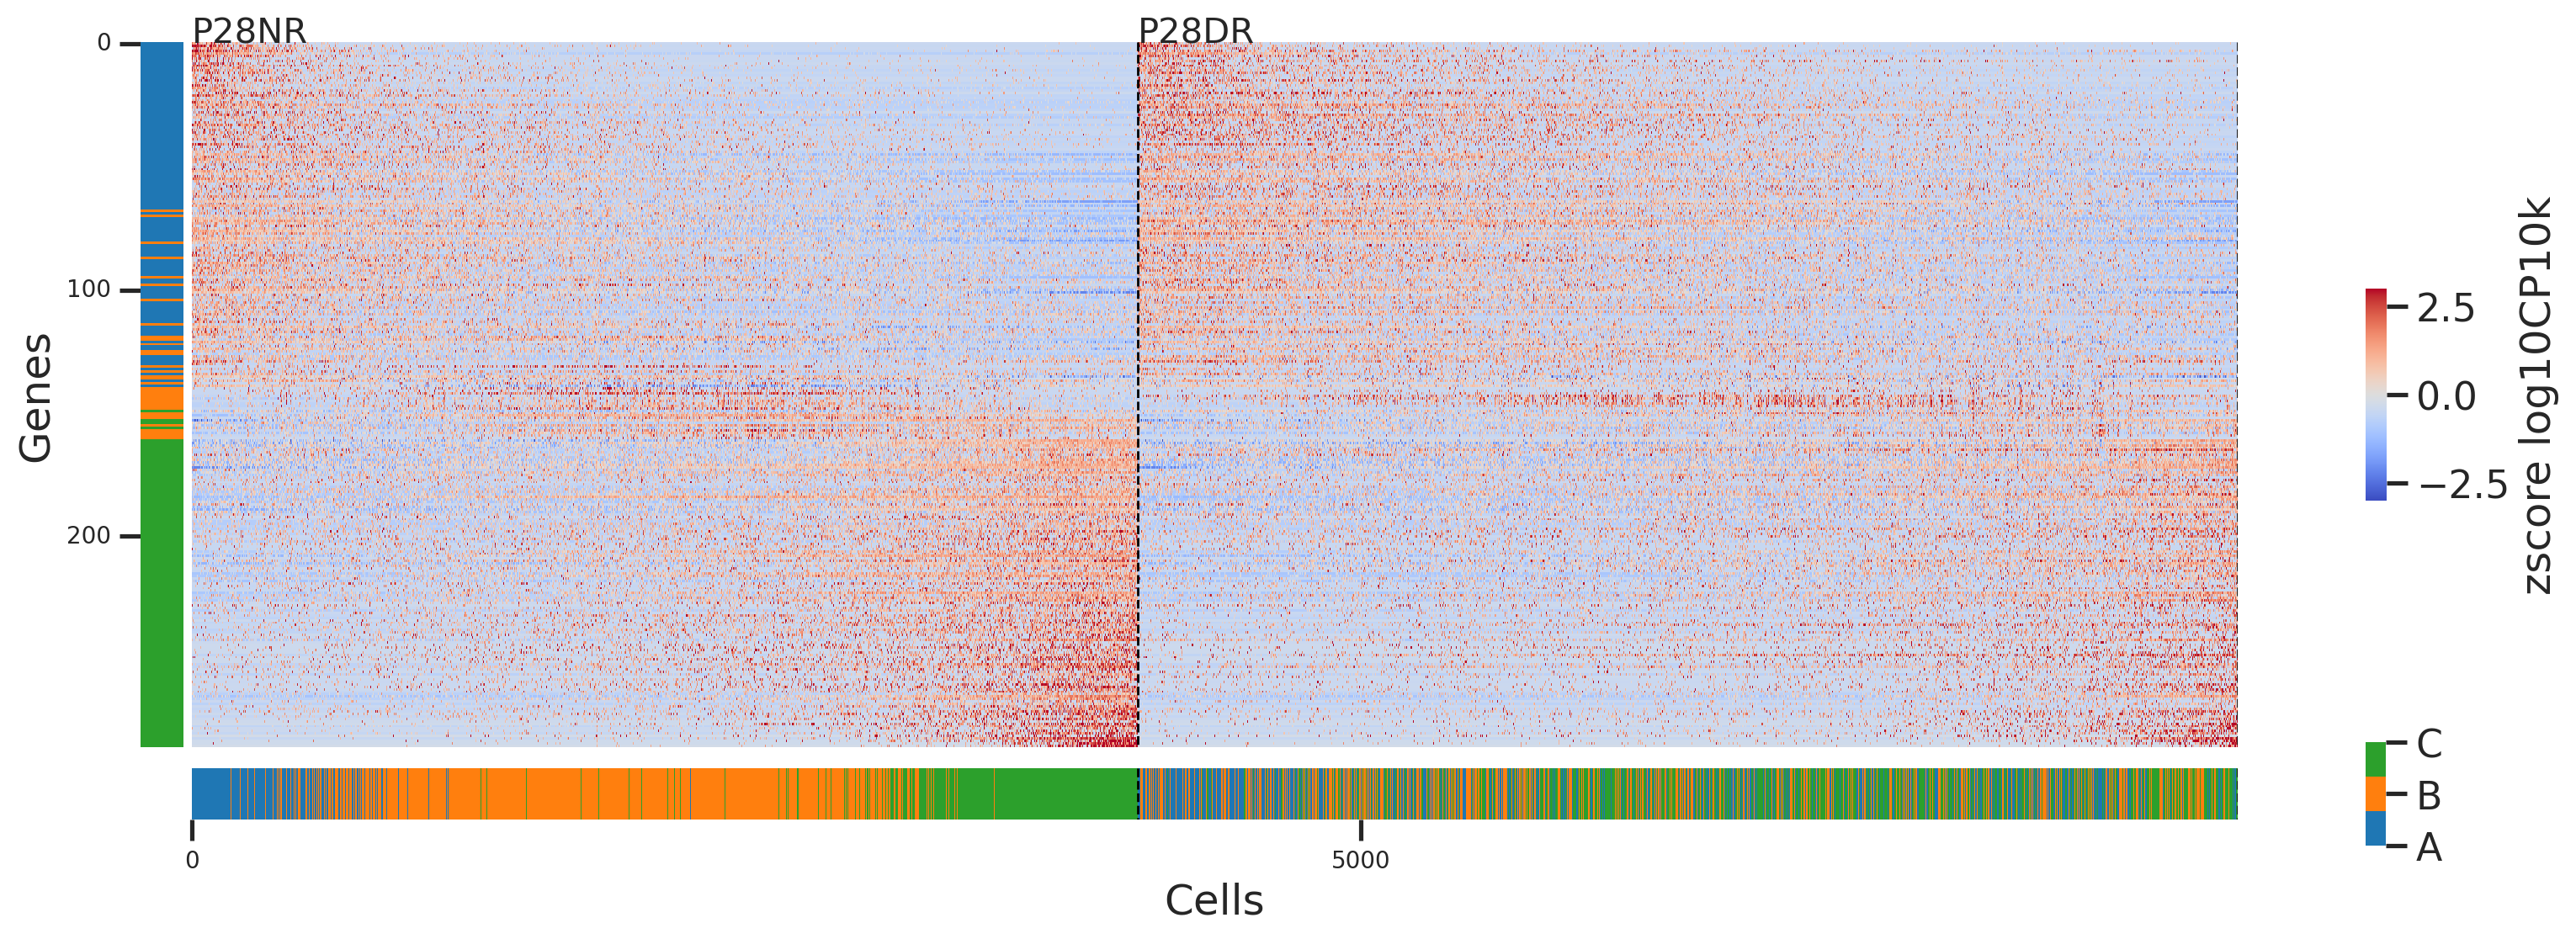

In [23]:
print(np.percentile(bigmat, [0,5,95,100]))

fig, axdict = plot(bigmat, np.arange(len(bigmat)), geneidx, bigtypes, genes_grp, "",
                   figsize=(20,6), xticklabels=5000, hratio=50)
axdict['A'].vlines(np.cumsum(ncases), 0, bigmat.shape[1], color='k', linestyle='--', linewidth=1)
axdict['C'].vlines(np.cumsum(ncases), 0, 1, color='k', linestyle='--', linewidth=1)
for x, case in zip(np.hstack([[0], np.cumsum(ncases)]), cases):
    axdict['A'].text(x, 0, case, fontsize=15)
plt.show()

# Quantify this 
- expression weighted by ptime

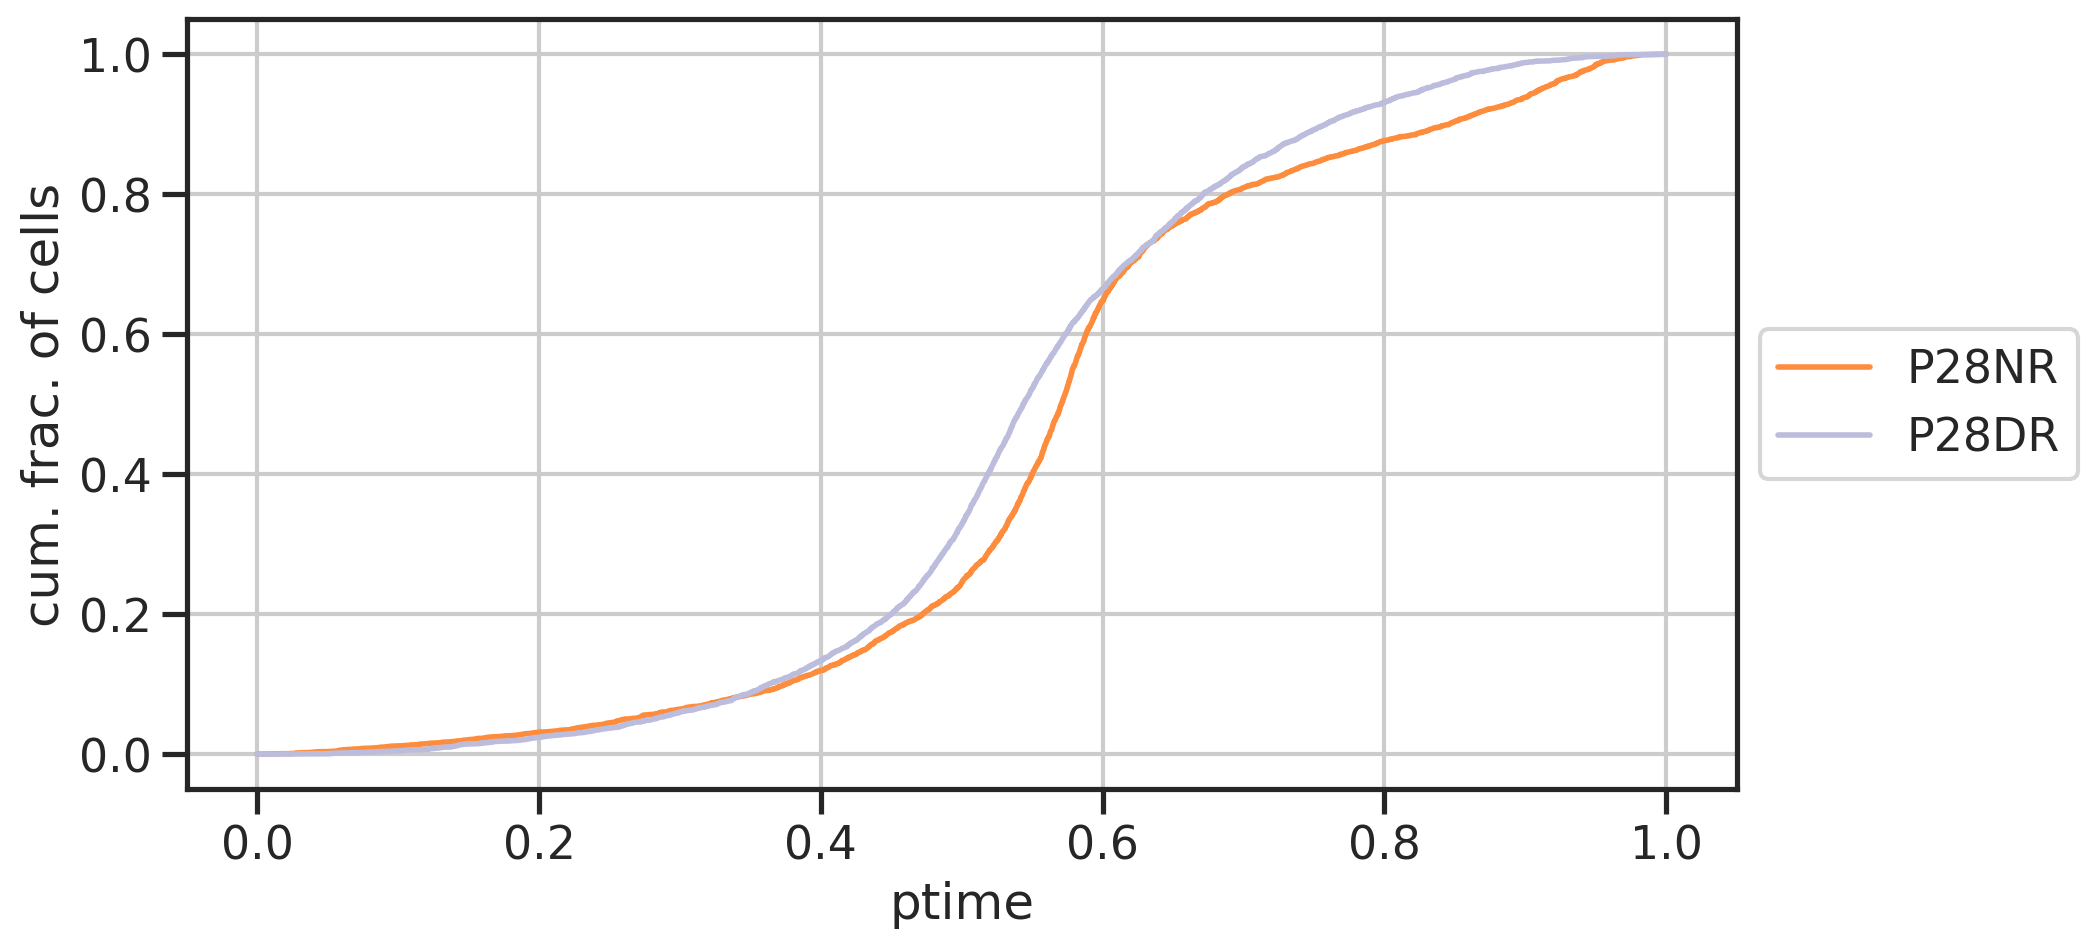

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
for case in cases:
    adata_sub = adata[adata.obs['cond']==case]
    ptime = dfall.loc[adata_sub.obs.index, 'ptime'].values
    ax.plot(np.sort(ptime), np.arange(len(ptime))/len(ptime), label=case, color=palette[case], linewidth=2)
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
ax.set_xlabel("ptime")
ax.set_ylabel("cum. frac. of cells")
plt.show()

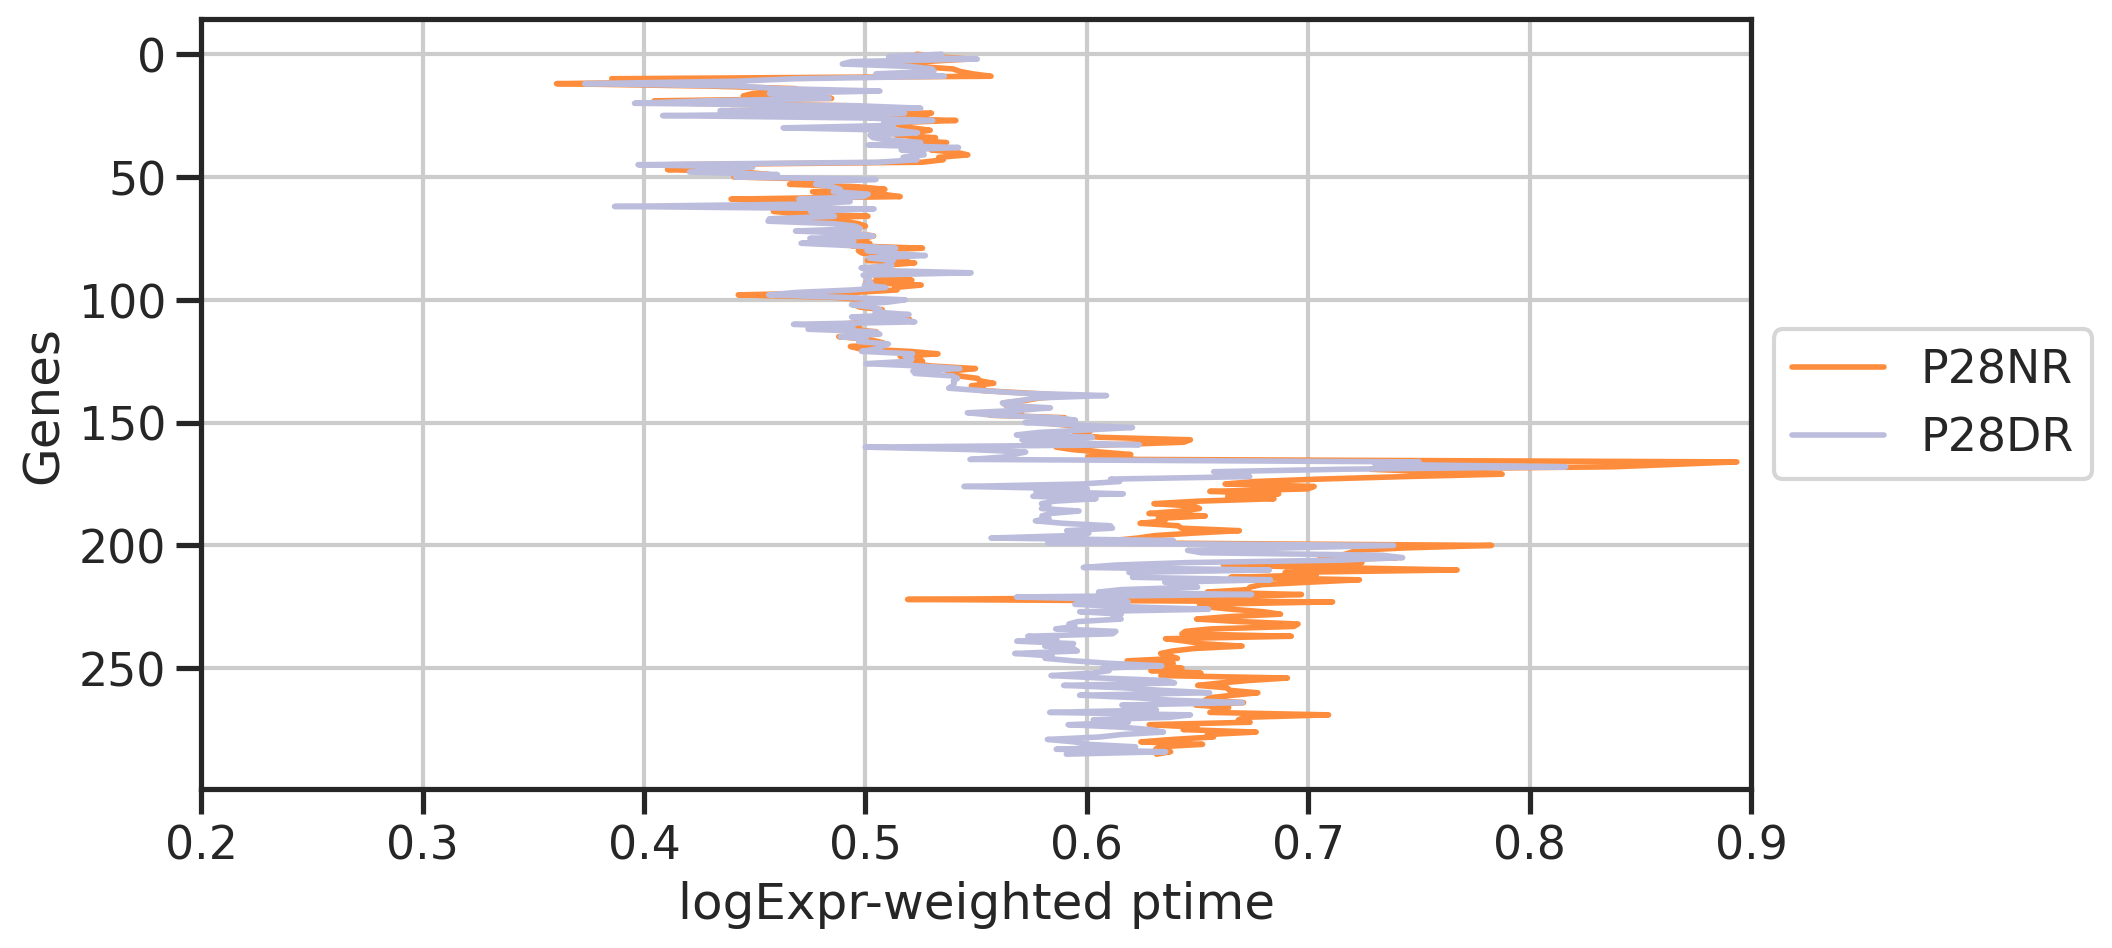

In [25]:
# adata.obs
fig, ax = plt.subplots(figsize=(10,5))
for case in cases:
    adata_sub = adata[adata.obs['cond']==case]
    zexpr = np.array(adata_sub.layers['zlog10CP10k'])
    wexpr = np.exp(zexpr)
    wexpr = wexpr/np.sum(wexpr, axis=0)
    corrd = dfall.loc[adata_sub.obs.index, 'ptime'].values
    
    gcrrd = wexpr.T.dot(corrd)
    ax.plot(gcrrd, np.arange(ngene), label=case, color=palette[case], linewidth=2)
    
ax.invert_yaxis()
ax.set_xlim([0.2,0.9])
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
ax.set_xlabel('logExpr-weighted ptime')
ax.set_ylabel('Genes')
plt.show()

# Specific genes

In [26]:
genes_subsel = [
    'Cdh13', 
    'Adamts2', 
    
    'Trpc6', 
    'Baz1a', 
    
    'Chrm2', 
    'Grik3', 
]
genes_grp_subsel = np.array([
    'A', 'A', 
    'B', 'B',
    'C', 'C',
])
gidx_subsel = basicu.get_index_from_array(genes_sel, genes_subsel)
gidx_subsel


array([ 11,  10, 137, 149, 200, 167])

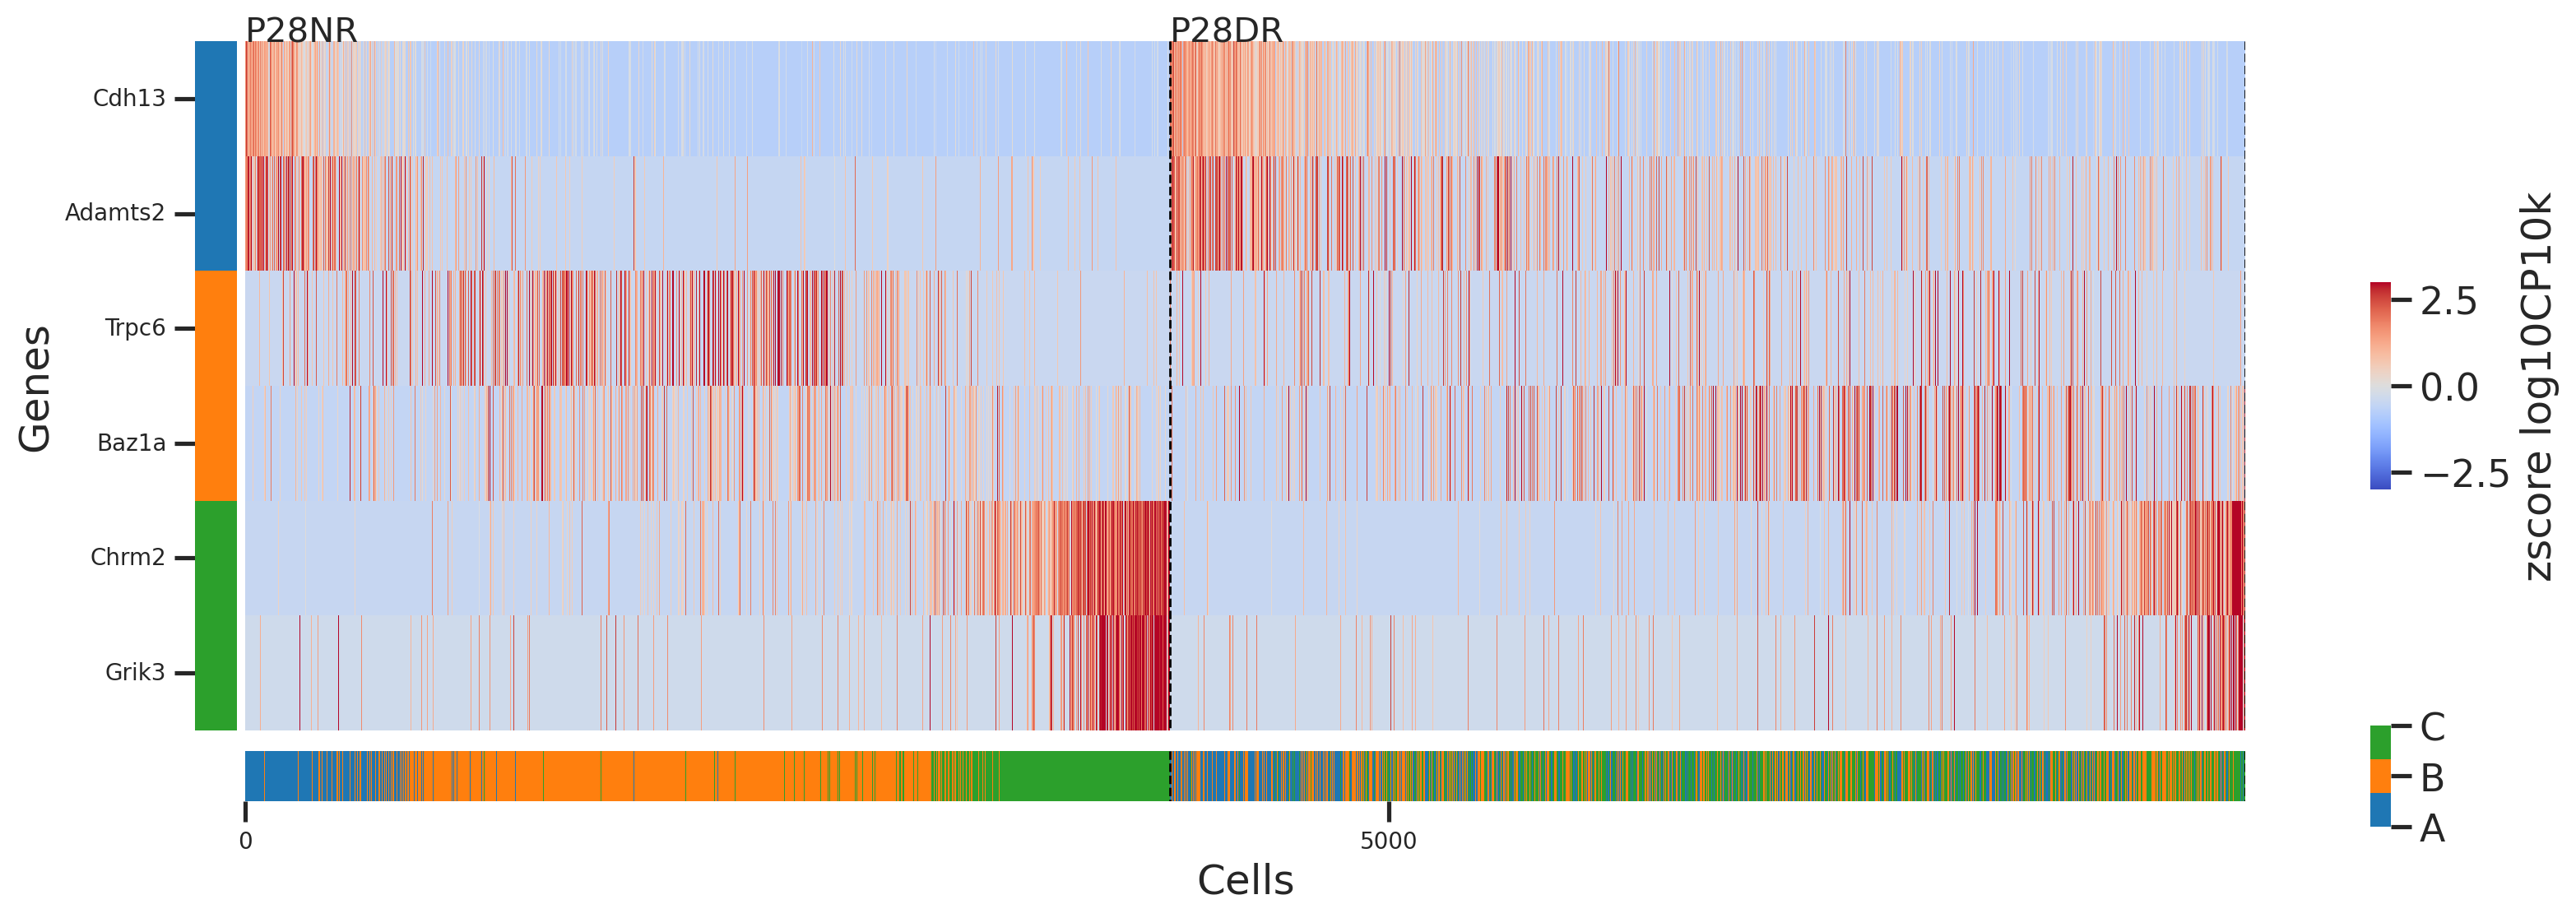

In [27]:
fig, axdict = plot(bigmat[:,gidx_subsel], np.arange(len(bigmat)), 
                   np.arange(len(genes_subsel)), bigtypes, genes_grp_subsel, "", 
                   figsize=(20,6), xticklabels=5000, yticklabels=genes_subsel, hratio=50)

axdict['A'].vlines(np.cumsum(ncases), 0, bigmat.shape[1], color='k', linestyle='--', linewidth=1)
axdict['C'].vlines(np.cumsum(ncases), 0, 1, color='k', linestyle='--', linewidth=1)
for x, case in zip(np.hstack([[0], np.cumsum(ncases)]), cases):
    axdict['A'].text(x, 0, case, fontsize=15)
plt.show()

# Ephs and Ephrins

In [28]:
adata

AnnData object with n_obs × n_vars = 8748 × 286
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'easitype', 'umap1', 'umap2', 'easisamp'
    obsm: 'X_pca'
    layers: 'log10CP10k', 'zlog10CP10k'

In [29]:
adata_raw

View of AnnData object with n_obs × n_vars = 8748 × 53801
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond'

In [30]:
genes_new = [
    'Cdh13', 
    'Adamts2', 
    
    'Trpc6', 
    'Baz1a', 
    
    'Chrm2', 
    'Grik3', 
    
    # ephs
    'Epha1', 'Epha2', 'Epha3', 'Epha4', 'Epha5', 'Epha6', 'Epha7', 'Epha8', 'Epha10', 
    'Ephb1', 'Ephb2', 'Ephb3', 'Ephb4', 'Ephb6',
    
    # ephrins
    'Efna1', 'Efna2', 'Efna3', 'Efna4', 'Efna5', 
    'Efnb1', 'Efnb2', 'Efnb3',
    
#     'Nr4a2', 'Nr4a3', 'Fos', 'Arl5b', 
#     'Col19a1', 'Scube1', 'Ptchd4', 'Nell1',
    ]
gi2 = basicu.get_index_from_array(allgenes, genes_new)
assert np.all(gi2 != -1)

In [31]:
# a big table of everything
allcells = adata.obs.index.values
bigmat = []
bigtypes = []
bigsamps = []
ncases = []
for case in cases:
    # select cells
    adata_sub = adata[adata.obs['cond']==case]
    cells_sub = adata_sub.obs.index.values
    cellsidx_sub = basicu.get_index_from_array(allcells, cells_sub)
    
    dfall_sub = dfall.loc[cells_sub]
    
    ftrs_sub  = adata_raw[cells_sub].X
    cov = np.ravel(ftrs_sub.sum(axis=1))
    ftrs_sub  = np.log10(np.asarray(ftrs_sub[:,gi2].todense())/cov.reshape(-1,1)*1e4+1)
    
    # order cells
    types   = adata_sub.obs['easitype'].values
    samps   = adata_sub.obs['easisamp'].values
    cellidx = np.argsort(dfall_sub['ptime'].values)
    
    bigmat.append(ftrs_sub[cellidx])
    bigtypes.append(types[cellidx])
    bigsamps.append(samps[cellidx])
    ncases.append(len(cellidx))
    
bigmat = np.vstack(bigmat)
bigmat = zscore(bigmat, axis=0)
bigtypes = np.hstack(bigtypes)
bigsamps = np.hstack(bigsamps)
bigmat.shape

(8748, 28)

[-3.76587486 -0.83365703  1.80365415 52.53087234]


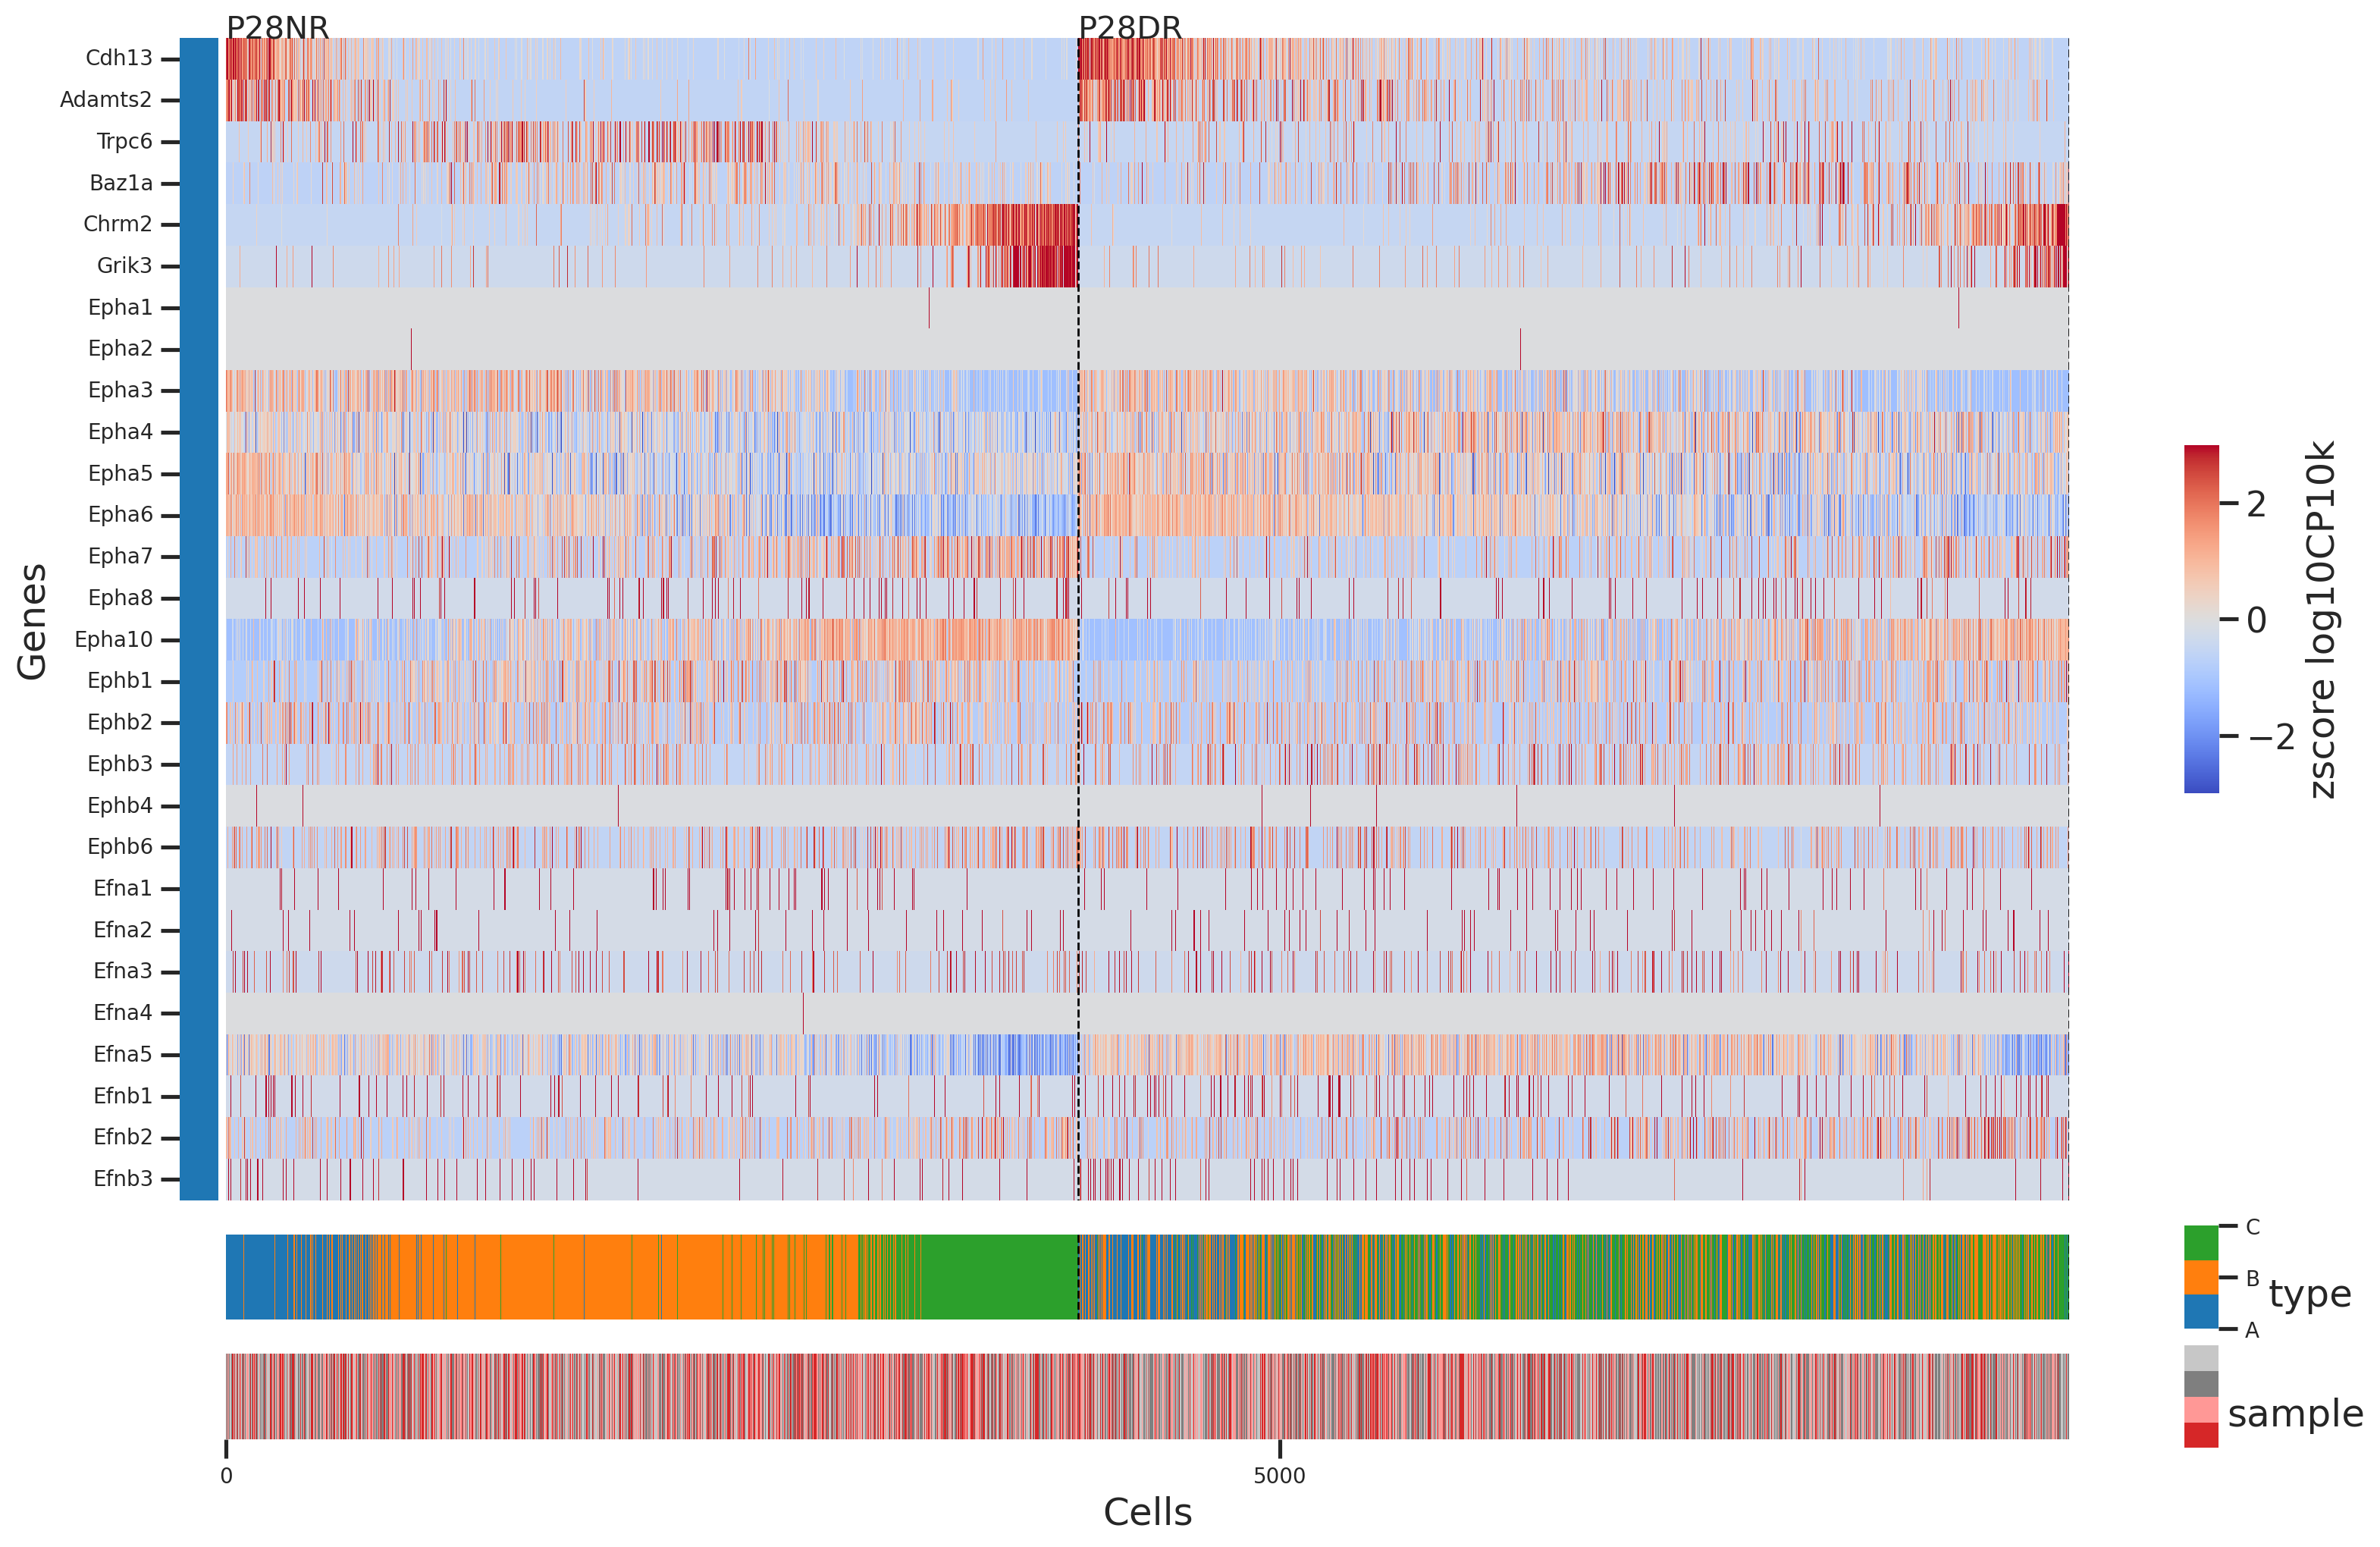

In [32]:
print(np.percentile(bigmat, [0,5,95,100]))

fig, axdict = plot2(bigmat, np.arange(len(bigmat)), np.arange(bigmat.shape[1]), bigtypes, 
                    np.array(['A']*len(genes_new)), "", bigsamps, 
                   figsize=(20,12), xticklabels=5000, yticklabels=genes_new, hratio=50) # , vmax=None, vmin=None, vcenter=None)
axdict['A'].vlines(np.cumsum(ncases), 0, bigmat.shape[1], color='k', linestyle='--', linewidth=1)
axdict['C'].vlines(np.cumsum(ncases), 0, 1, color='k', linestyle='--', linewidth=1)
for x, case in zip(np.hstack([[0], np.cumsum(ncases)]), cases):
    axdict['A'].text(x, 0, case, fontsize=15)
plt.show()

# DR regulated genes

In [33]:
adata

AnnData object with n_obs × n_vars = 8748 × 286
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'easitype', 'umap1', 'umap2', 'easisamp'
    obsm: 'X_pca'
    layers: 'log10CP10k', 'zlog10CP10k'

In [34]:
adata_raw

View of AnnData object with n_obs × n_vars = 8748 × 53801
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond'

In [35]:
genes_new = [
    'Igfn1', 'Col26a1', 'Nell1', 'Col11a1', 'Hkdc1', 'Olfm3', 'Golim4',
    'Lemd1', 'Clmp', 'Neu2', 'Mei1', 'Cpne9', 'Slc24a3', 'Etl4',
    'Sgpp2', 'Epb41', 'Pcsk5', 'Tmem232', 'Astn2', 'Ntn4', 'Afap1l1',
    'Zfp618', 'Npr3', '3632451O06Rik', 'Arhgap42', 'Heg1', 'Vwc2l',
    'Tmem117', 'Kcnk13', 'Airn', 'Ttc28', 'Col23a1', 'Cdh13', 'Glis3',
    'Iqgap2', 'Nckap5', 'Cpne6', '1700086L19Rik', 'Otof', 'Pcdh19',
    'Sema6a', 'Gm42722', 'Gabrg3', 'Grm8', 'Palm2', 'Syt17', 'Kctd8',
    'Nefm', 'Cbln2', 'Ell2', 'Npas4', 'Bdnf', 'Nptx2', 'Myh9', 'Scg3',
]
    
#     'Cdh13', 
#     'Adamts2', 
    
#     'Trpc6', 
#     'Baz1a', 
    
#     'Chrm2', 
#     'Grik3', 
    
#     'Nr4a2', 'Nr4a3', 'Fos', 'Arl5b', 
#     'Col19a1', 'Scube1', 'Ptchd4', 'Nell1',
    
gi2 = basicu.get_index_from_array(allgenes, genes_new)
assert np.all(gi2 != -1)

In [36]:
# a big table of everything
allcells = adata.obs.index.values
bigmat = []
bigtypes = []
bigsamps = []
ncases = []
for case in cases:
    # select cells
    adata_sub = adata[adata.obs['cond']==case]
    cells_sub = adata_sub.obs.index.values
    cellsidx_sub = basicu.get_index_from_array(allcells, cells_sub)
    
    dfall_sub = dfall.loc[cells_sub]
    
    ftrs_sub  = adata_raw[cells_sub].X
    cov = np.ravel(ftrs_sub.sum(axis=1))
    ftrs_sub  = np.log10(np.asarray(ftrs_sub[:,gi2].todense())/cov.reshape(-1,1)*1e4+1)
    
    # order cells
    types   = adata_sub.obs['easitype'].values
    samps   = adata_sub.obs['easisamp'].values
    cellidx = np.argsort(dfall_sub['ptime'].values)
    
    bigmat.append(ftrs_sub[cellidx])
    bigtypes.append(types[cellidx])
    bigsamps.append(samps[cellidx])
    ncases.append(len(cellidx))
    
bigmat = np.vstack(bigmat)
bigmat = zscore(bigmat, axis=0)
bigtypes = np.hstack(bigtypes)
bigsamps = np.hstack(bigsamps)
bigmat.shape

(8748, 55)

[-1.99308205 -0.85225546  2.10884256  9.06771469]


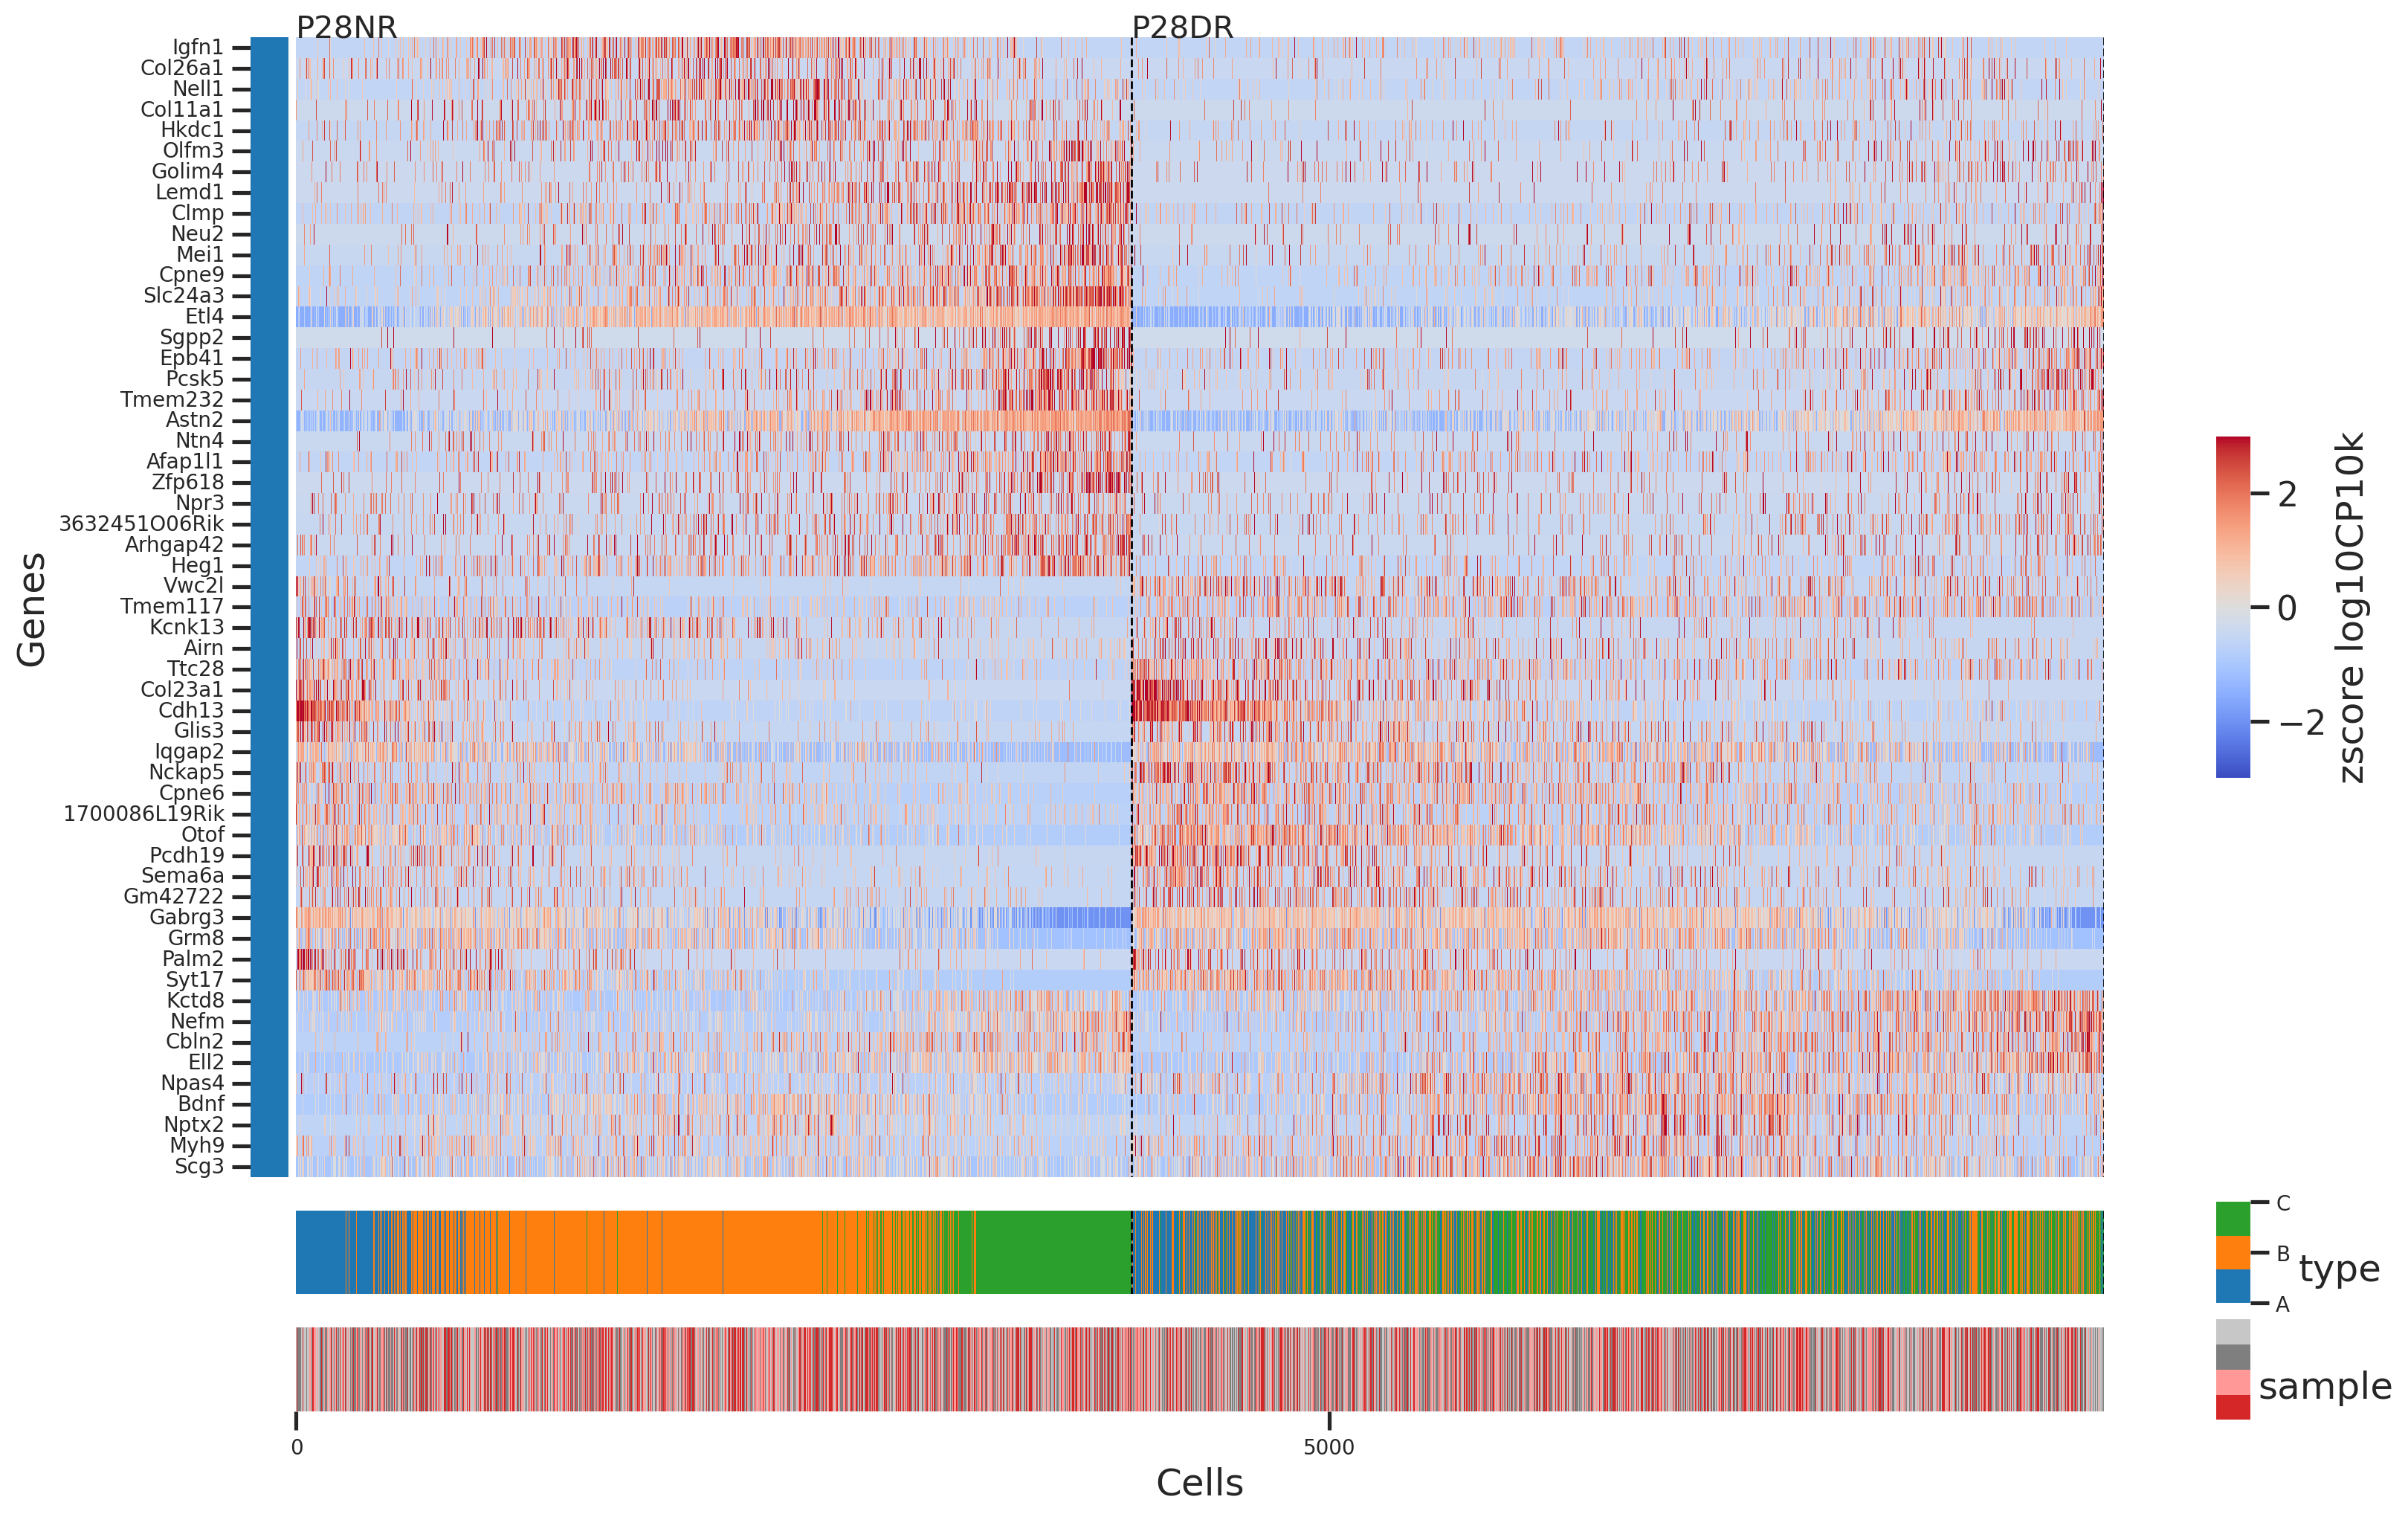

In [37]:
print(np.percentile(bigmat, [0,5,95,100]))

fig, axdict = plot2(bigmat, np.arange(len(bigmat)), np.arange(bigmat.shape[1]), bigtypes, 
                    np.array(['A']*len(genes_new)), "", bigsamps, 
                   figsize=(20,12), xticklabels=5000, yticklabels=genes_new, hratio=50) # , vmax=None, vmin=None, vcenter=None)
axdict['A'].vlines(np.cumsum(ncases), 0, bigmat.shape[1], color='k', linestyle='--', linewidth=1)
axdict['C'].vlines(np.cumsum(ncases), 0, 1, color='k', linestyle='--', linewidth=1)
for x, case in zip(np.hstack([[0], np.cumsum(ncases)]), cases):
    axdict['A'].text(x, 0, case, fontsize=15)
plt.show()

# DR regulated genes - reordered

In [38]:
genes_new = [
    'Igfn1', 'Col26a1', 'Nell1', 'Col11a1', 'Hkdc1', 'Olfm3', 'Golim4',
    'Lemd1', 'Clmp', 'Neu2', 'Mei1', 'Cpne9', 'Slc24a3', 'Etl4',
    'Sgpp2', 'Epb41', 'Pcsk5', 'Tmem232', 'Astn2', 'Ntn4', 'Afap1l1',
    'Zfp618', 'Npr3', '3632451O06Rik', 'Arhgap42', 'Heg1', 'Vwc2l',
    'Tmem117', 'Kcnk13', 'Airn', 'Ttc28', 'Col23a1', 'Cdh13', 'Glis3',
    'Iqgap2', 'Nckap5', 'Cpne6', '1700086L19Rik', 'Otof', 'Pcdh19',
    'Sema6a', 'Gm42722', 'Gabrg3', 'Grm8', 'Palm2', 'Syt17', 'Kctd8',
    'Nefm', 'Cbln2', 'Ell2', 'Npas4', 'Bdnf', 'Nptx2', 'Myh9', 'Scg3',
]
    
# reorder it according to GPT    
genes_new = gpt_df.set_index('gene').loc[genes_new].sort_values('gene_ptime').index.values
gi2 = basicu.get_index_from_array(allgenes, genes_new)
assert np.all(gi2 != -1)

In [39]:
# a big table of everything
allcells = adata.obs.index.values
bigmat = []
bigtypes = []
bigsamps = []
ncases = []
for case in cases:
    # select cells
    adata_sub = adata[adata.obs['cond']==case]
    cells_sub = adata_sub.obs.index.values
    cellsidx_sub = basicu.get_index_from_array(allcells, cells_sub)
    
    dfall_sub = dfall.loc[cells_sub]
    
    ftrs_sub  = adata_raw[cells_sub].X
    cov = np.ravel(ftrs_sub.sum(axis=1))
    ftrs_sub  = np.log10(np.asarray(ftrs_sub[:,gi2].todense())/cov.reshape(-1,1)*1e4+1)
    
    # order cells
    types   = adata_sub.obs['easitype'].values
    samps   = adata_sub.obs['easisamp'].values
    cellidx = np.argsort(dfall_sub['ptime'].values)
    
    bigmat.append(ftrs_sub[cellidx])
    bigtypes.append(types[cellidx])
    bigsamps.append(samps[cellidx])
    ncases.append(len(cellidx))
    
bigmat = np.vstack(bigmat)
bigmat = zscore(bigmat, axis=0)
bigtypes = np.hstack(bigtypes)
bigsamps = np.hstack(bigsamps)
bigmat.shape

(8748, 55)

[-1.99308205 -0.85225546  2.10884256  9.06771469]


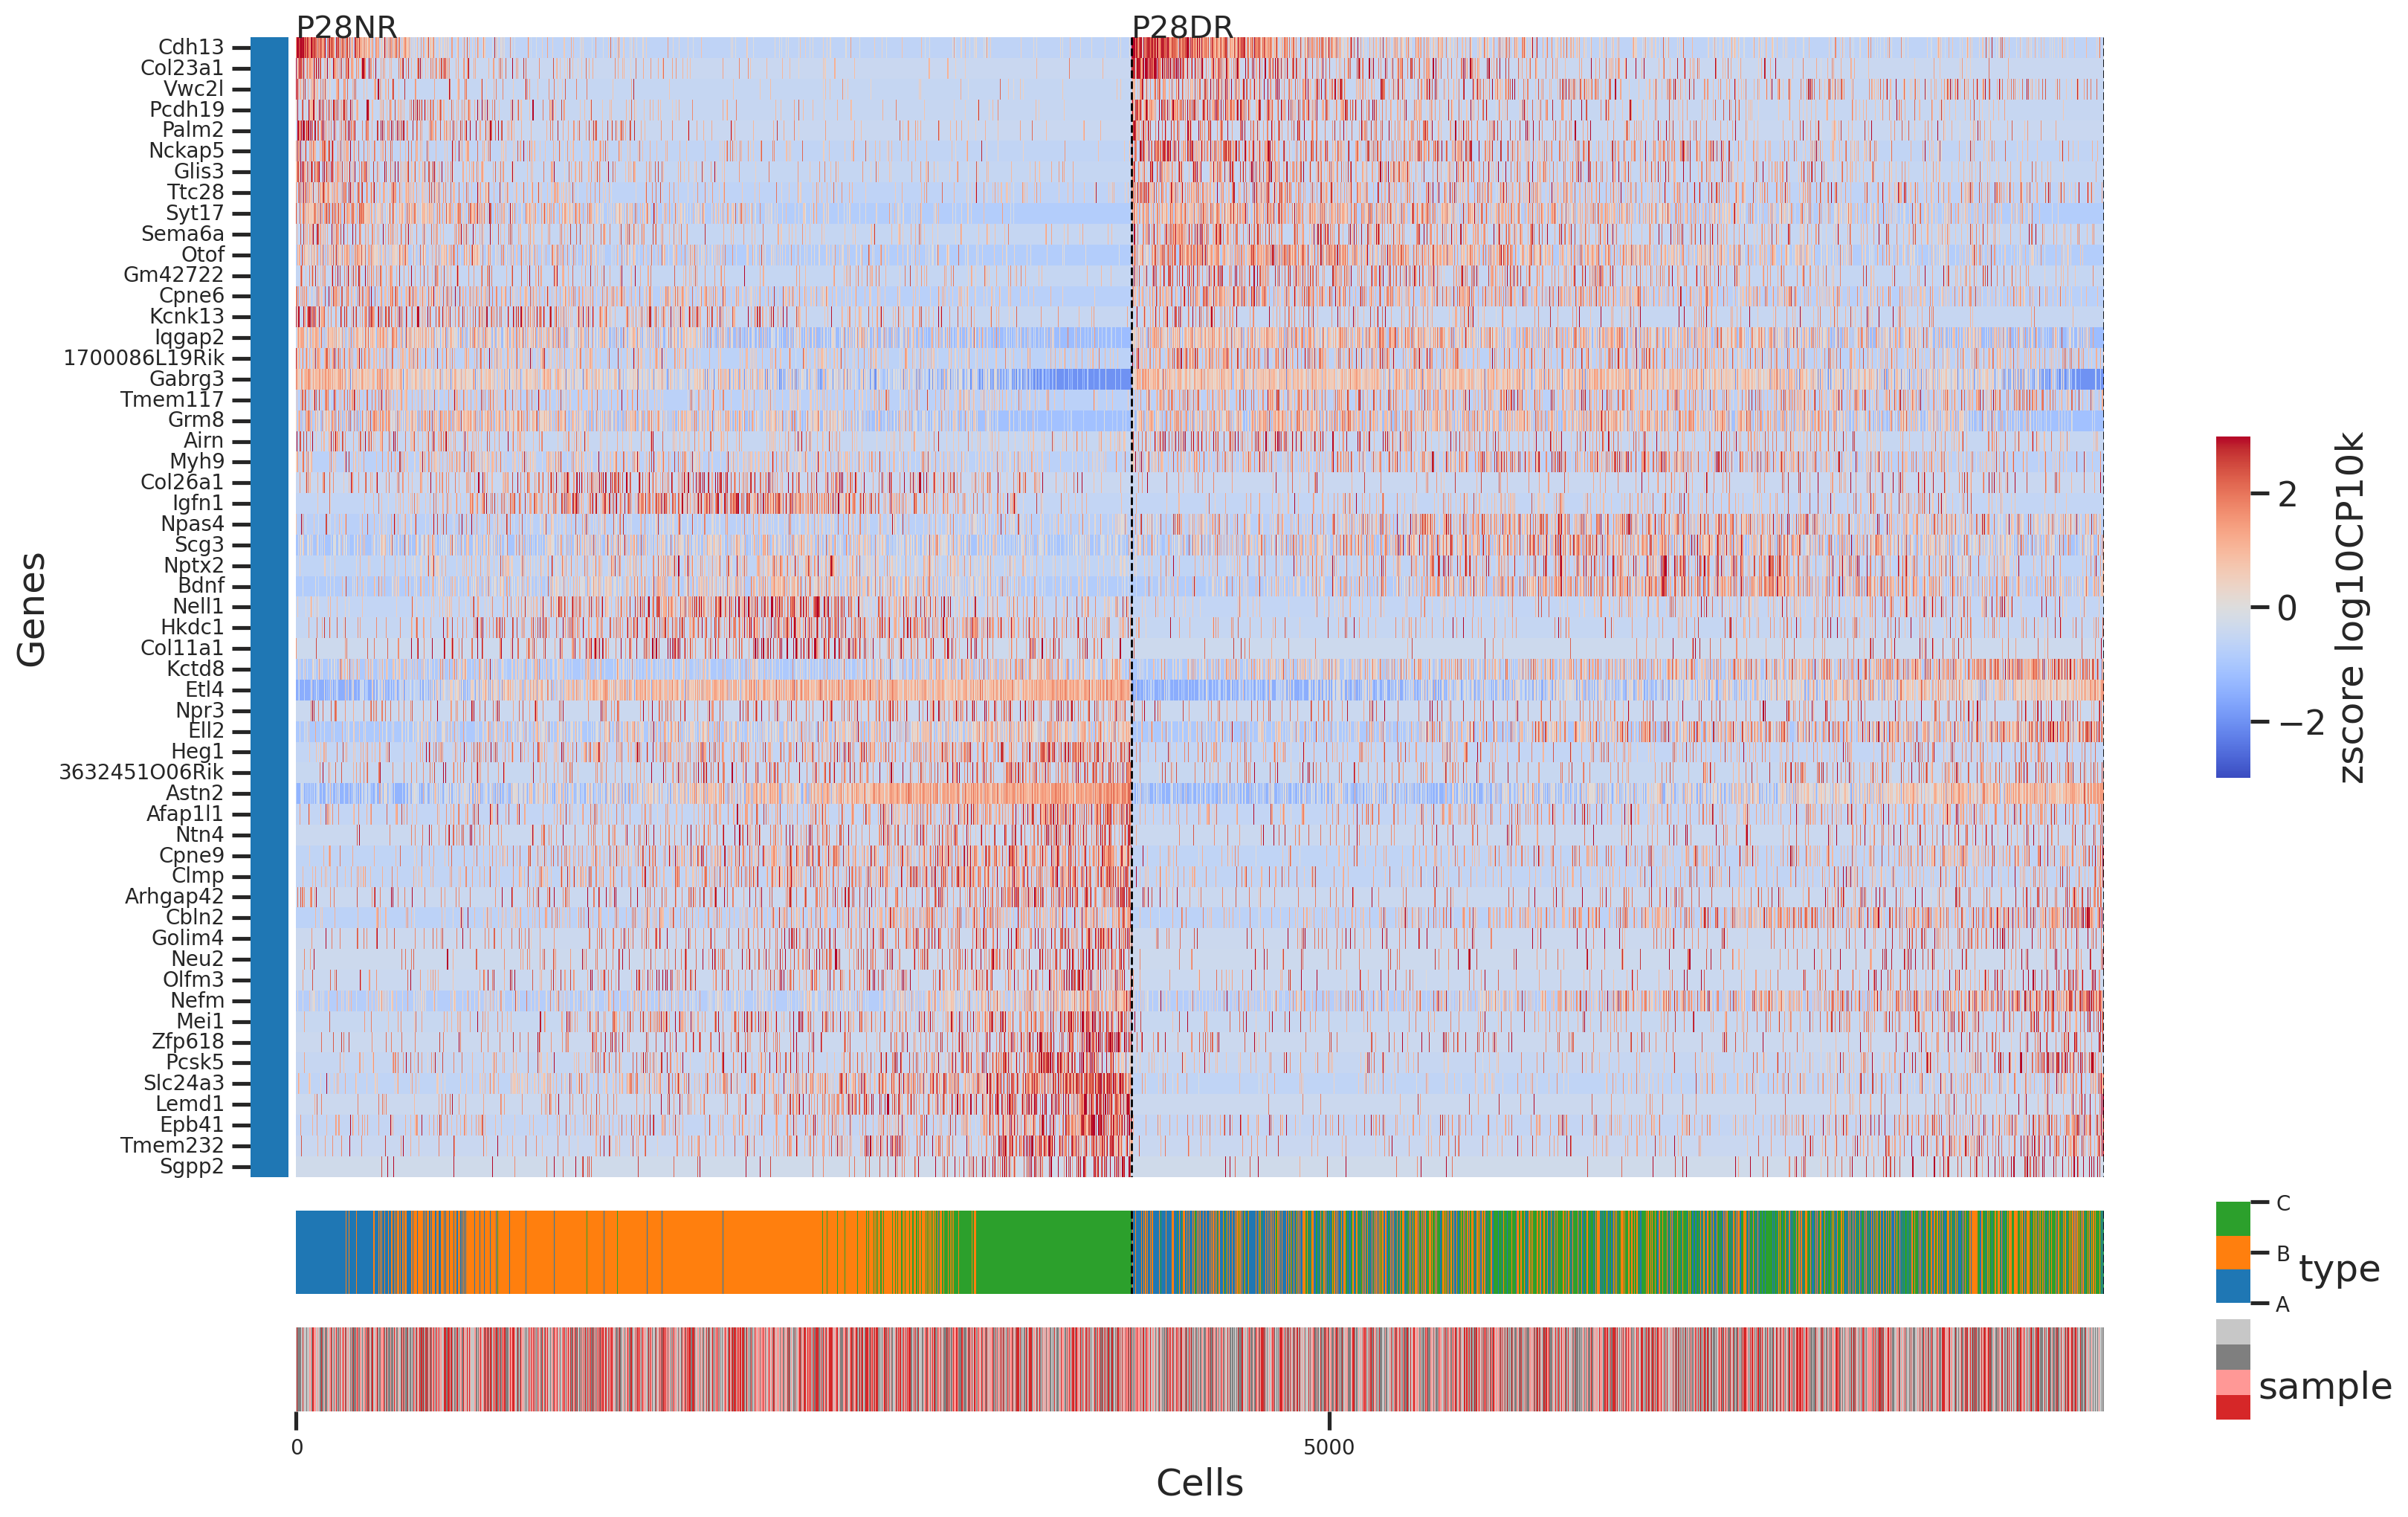

In [40]:
print(np.percentile(bigmat, [0,5,95,100]))

fig, axdict = plot2(bigmat, np.arange(len(bigmat)), np.arange(bigmat.shape[1]), bigtypes, 
                    np.array(['A']*len(genes_new)), "", bigsamps, 
                   figsize=(20,12), xticklabels=5000, yticklabels=genes_new, hratio=50) # , vmax=None, vmin=None, vcenter=None)
axdict['A'].vlines(np.cumsum(ncases), 0, bigmat.shape[1], color='k', linestyle='--', linewidth=1)
axdict['C'].vlines(np.cumsum(ncases), 0, 1, color='k', linestyle='--', linewidth=1)
for x, case in zip(np.hstack([[0], np.cumsum(ncases)]), cases):
    axdict['A'].text(x, 0, case, fontsize=15)
plt.show()

# non-DR regulated genes - reordered

In [41]:
genes_new = [
    'Igfn1', 'Col26a1', 'Nell1', 'Col11a1', 'Hkdc1', 'Olfm3', 'Golim4',
    'Lemd1', 'Clmp', 'Neu2', 'Mei1', 'Cpne9', 'Slc24a3', 'Etl4',
    'Sgpp2', 'Epb41', 'Pcsk5', 'Tmem232', 'Astn2', 'Ntn4', 'Afap1l1',
    'Zfp618', 'Npr3', '3632451O06Rik', 'Arhgap42', 'Heg1', 'Vwc2l',
    'Tmem117', 'Kcnk13', 'Airn', 'Ttc28', 'Col23a1', 'Cdh13', 'Glis3',
    'Iqgap2', 'Nckap5', 'Cpne6', '1700086L19Rik', 'Otof', 'Pcdh19',
    'Sema6a', 'Gm42722', 'Gabrg3', 'Grm8', 'Palm2', 'Syt17', 'Kctd8',
    'Nefm', 'Cbln2', 'Ell2', 'Npas4', 'Bdnf', 'Nptx2', 'Myh9', 'Scg3',
]
non_drgenes = [g for g in gpt_df['gene'] if g not in genes_new]
genes_new = non_drgenes
    
# reorder it according to GPT    
genes_new = gpt_df.set_index('gene').loc[genes_new].sort_values('gene_ptime').index.values
gi2 = basicu.get_index_from_array(allgenes, genes_new)
assert np.all(gi2 != -1)

In [42]:
genes_new

array(['Met', '6530403H02Rik', 'Rhbdl3', 'Adamts2', 'Raver2', 'Syt10',
       'Spon1', 'Kcnn3', 'Arhgef28', 'Scml4', 'Ikzf2', 'Dpyd', 'Gpc5',
       'Slc6a7', 'Crispld1', 'Igsf11', 'Tenm1', 'Robo1', 'Adamts16',
       'Eda', 'Gm4876', 'Mgat4c', 'Glra3', 'Wdr66', 'Nov', 'Hap1', 'Tox3',
       'Cemip', 'Itga8', 'Wnt4', 'Sdk2', 'Pdzrn4', 'Plxnd1', 'Atp2b4',
       'Prkcg', 'Adcy10', 'Pnck', 'Zbtb20', 'Ryr3', 'Necab1', 'Ypel1',
       'Camk2d', 'Mmd2', 'Nfia', 'Pdgfc', 'Rasal1', 'Map2k6', 'Gab2',
       'Dscaml1', 'Reln', 'Npas3', 'Galnt17', 'Cntn5', 'Ly6h',
       'B230303A05Rik', 'Cys1', 'Ripor2', 'Rfx3', 'Slc7a14', 'Ust',
       'Grm1', 'Kirrel3', 'Epha3', 'March4', 'Sez6', 'Frmd4b', 'Prkag2',
       'Rgs8', 'Adcyap1r1', 'Nfib', 'Fkbp5', 'Wwc2', 'Acvr2a', 'Gtf2ird1',
       'Ccdc85a', 'Sox5', 'Zfp608', 'Grk3', 'Zfp804b', 'Crim1', 'Meis2',
       'Gpc6', 'C130026L21Rik', 'Mpp6', 'Tmeff1', 'Sh3gl3', 'Mdga1',
       'Slc16a2', 'Fam126a', 'Tiam1', 'Grb14', 'Nkain3', 'Gm35835',
       'Fam21

In [43]:
# a big table of everything
allcells = adata.obs.index.values
bigmat = []
bigtypes = []
bigsamps = []
ncases = []
for case in cases:
    # select cells
    adata_sub = adata[adata.obs['cond']==case]
    cells_sub = adata_sub.obs.index.values
    cellsidx_sub = basicu.get_index_from_array(allcells, cells_sub)
    
    dfall_sub = dfall.loc[cells_sub]
    
    ftrs_sub  = adata_raw[cells_sub].X
    cov = np.ravel(ftrs_sub.sum(axis=1))
    ftrs_sub  = np.log10(np.asarray(ftrs_sub[:,gi2].todense())/cov.reshape(-1,1)*1e4+1)
    
    # order cells
    types   = adata_sub.obs['easitype'].values
    samps   = adata_sub.obs['easisamp'].values
    cellidx = np.argsort(dfall_sub['ptime'].values)
    
    bigmat.append(ftrs_sub[cellidx])
    bigtypes.append(types[cellidx])
    bigsamps.append(samps[cellidx])
    ncases.append(len(cellidx))
    
bigmat = np.vstack(bigmat)
bigmat = zscore(bigmat, axis=0)
bigtypes = np.hstack(bigtypes)
bigsamps = np.hstack(bigsamps)
bigmat.shape

(8748, 231)

[-4.66484308 -1.05396104  1.94800305 10.49784565]


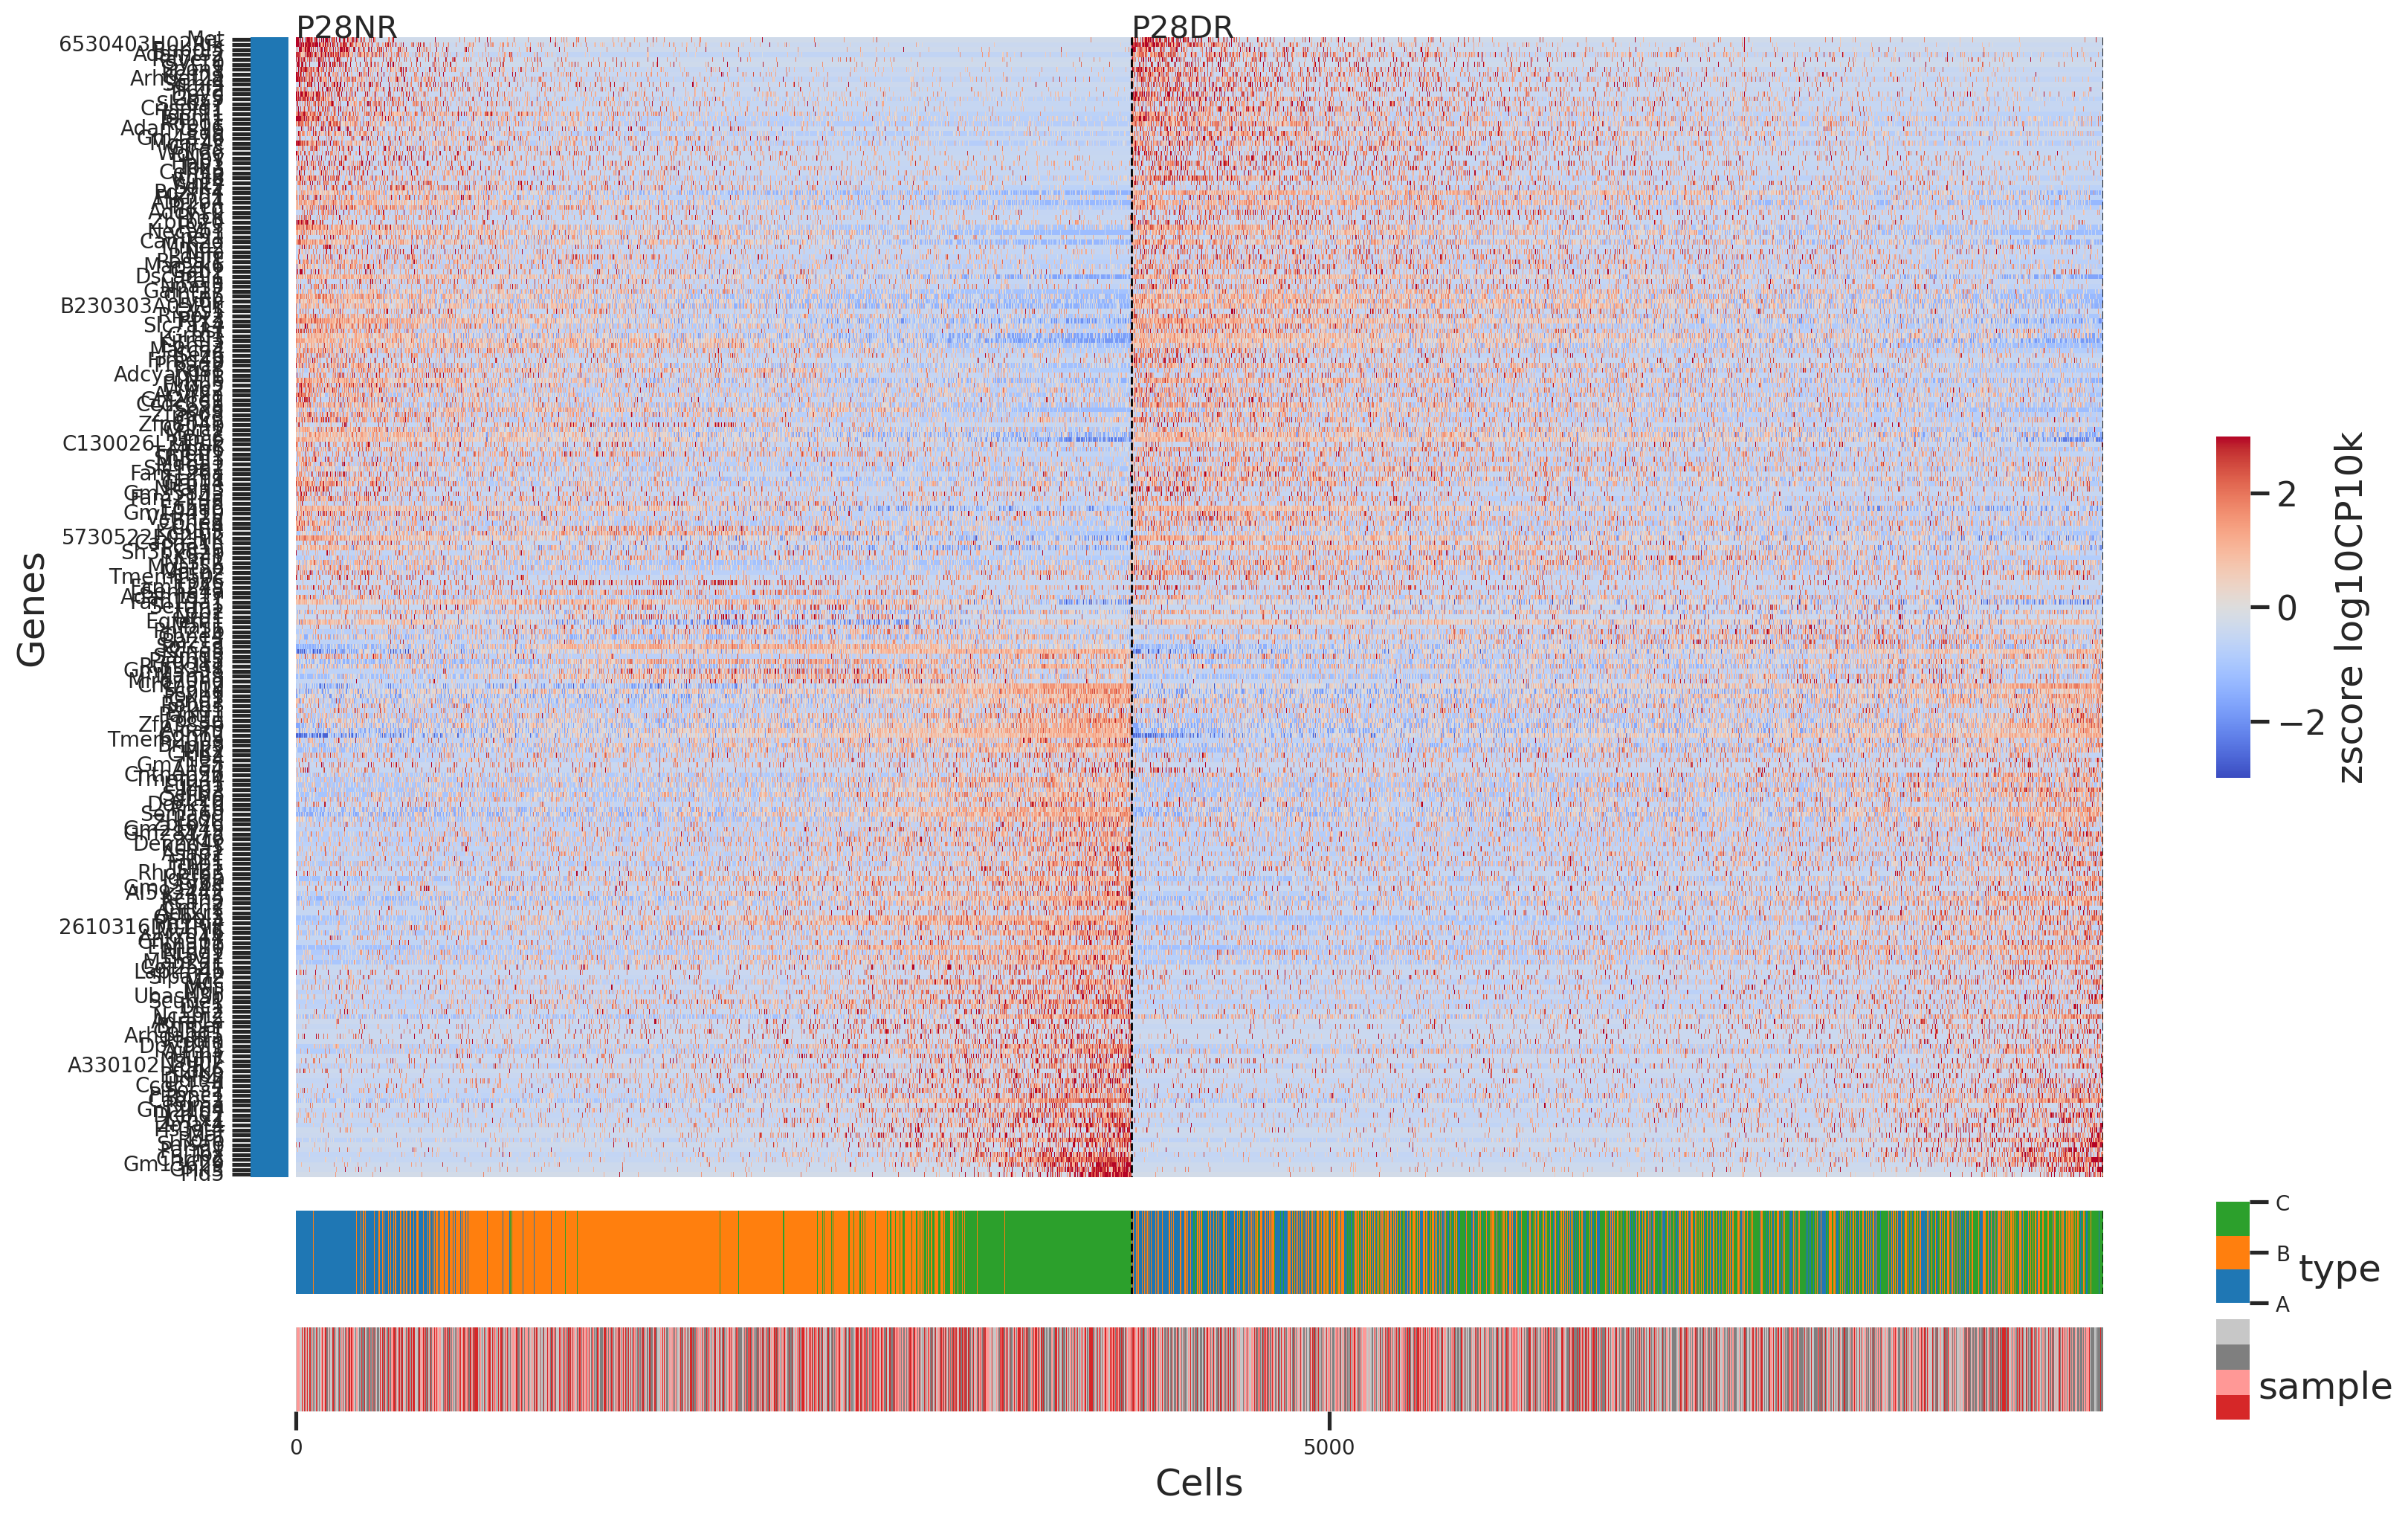

In [44]:
print(np.percentile(bigmat, [0,5,95,100]))

fig, axdict = plot2(bigmat, np.arange(len(bigmat)), np.arange(bigmat.shape[1]), bigtypes, 
                    np.array(['A']*len(genes_new)), "", bigsamps, 
                   figsize=(20,12), xticklabels=5000, yticklabels=genes_new, hratio=50) # , vmax=None, vmin=None, vcenter=None)
axdict['A'].vlines(np.cumsum(ncases), 0, bigmat.shape[1], color='k', linestyle='--', linewidth=1)
axdict['C'].vlines(np.cumsum(ncases), 0, 1, color='k', linestyle='--', linewidth=1)
for x, case in zip(np.hstack([[0], np.cumsum(ncases)]), cases):
    axdict['A'].text(x, 0, case, fontsize=15)
plt.show()

# quantify this
- DR regulated
- non-DR regulated

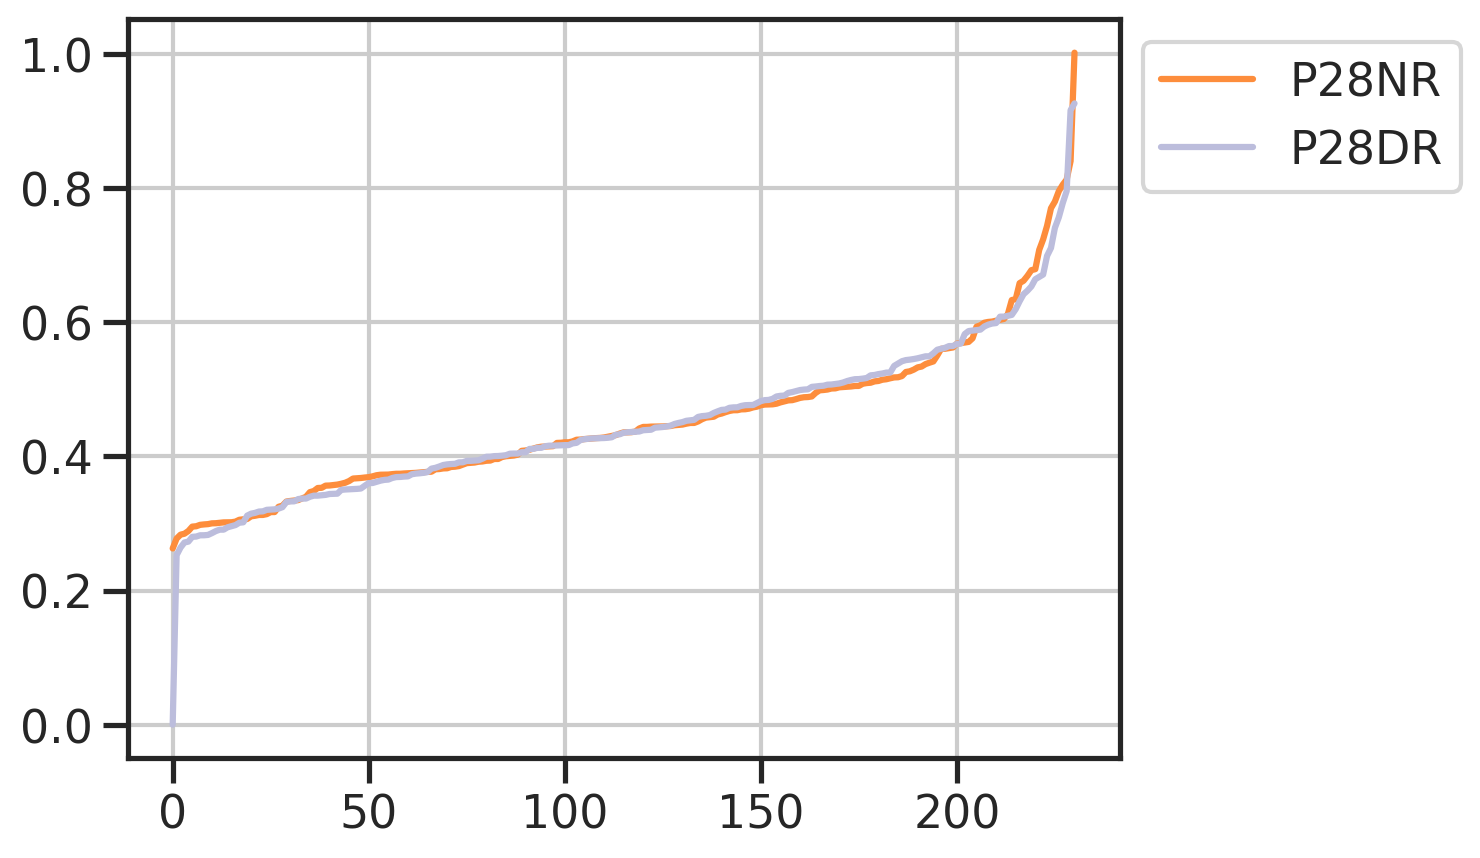

In [45]:
# a big table of everything
allcells = adata.obs.index.values
bigmat = []
bigtypes = []
bigsamps = []
ncases = []
for case in cases:
    # select cells
    adata_sub = adata[adata.obs['cond']==case]
    cells_sub = adata_sub.obs.index.values
    cellsidx_sub = basicu.get_index_from_array(allcells, cells_sub)
    
    dfall_sub = dfall.loc[cells_sub]
    
    ftrs_sub  = adata_raw[cells_sub].X
    cov = np.ravel(ftrs_sub.sum(axis=1))
    ftrs_sub  = np.log10(np.asarray(ftrs_sub[:,gi2].todense())/cov.reshape(-1,1)*1e4+1)
    
    # order cells
    types   = adata_sub.obs['easitype'].values
    samps   = adata_sub.obs['easisamp'].values
    cellidx = np.argsort(dfall_sub['ptime'].values)
    
    a = ftrs_sub[cellidx]  #.shape
    diff = np.percentile(a, 95, axis=0) - np.percentile(a, 50, axis=0)

    # plt.plot(diff, color=palette[case], label=case)
    plt.plot(np.sort(diff), color=palette[case], label=case)
plt.legend(bbox_to_anchor=(1,1))

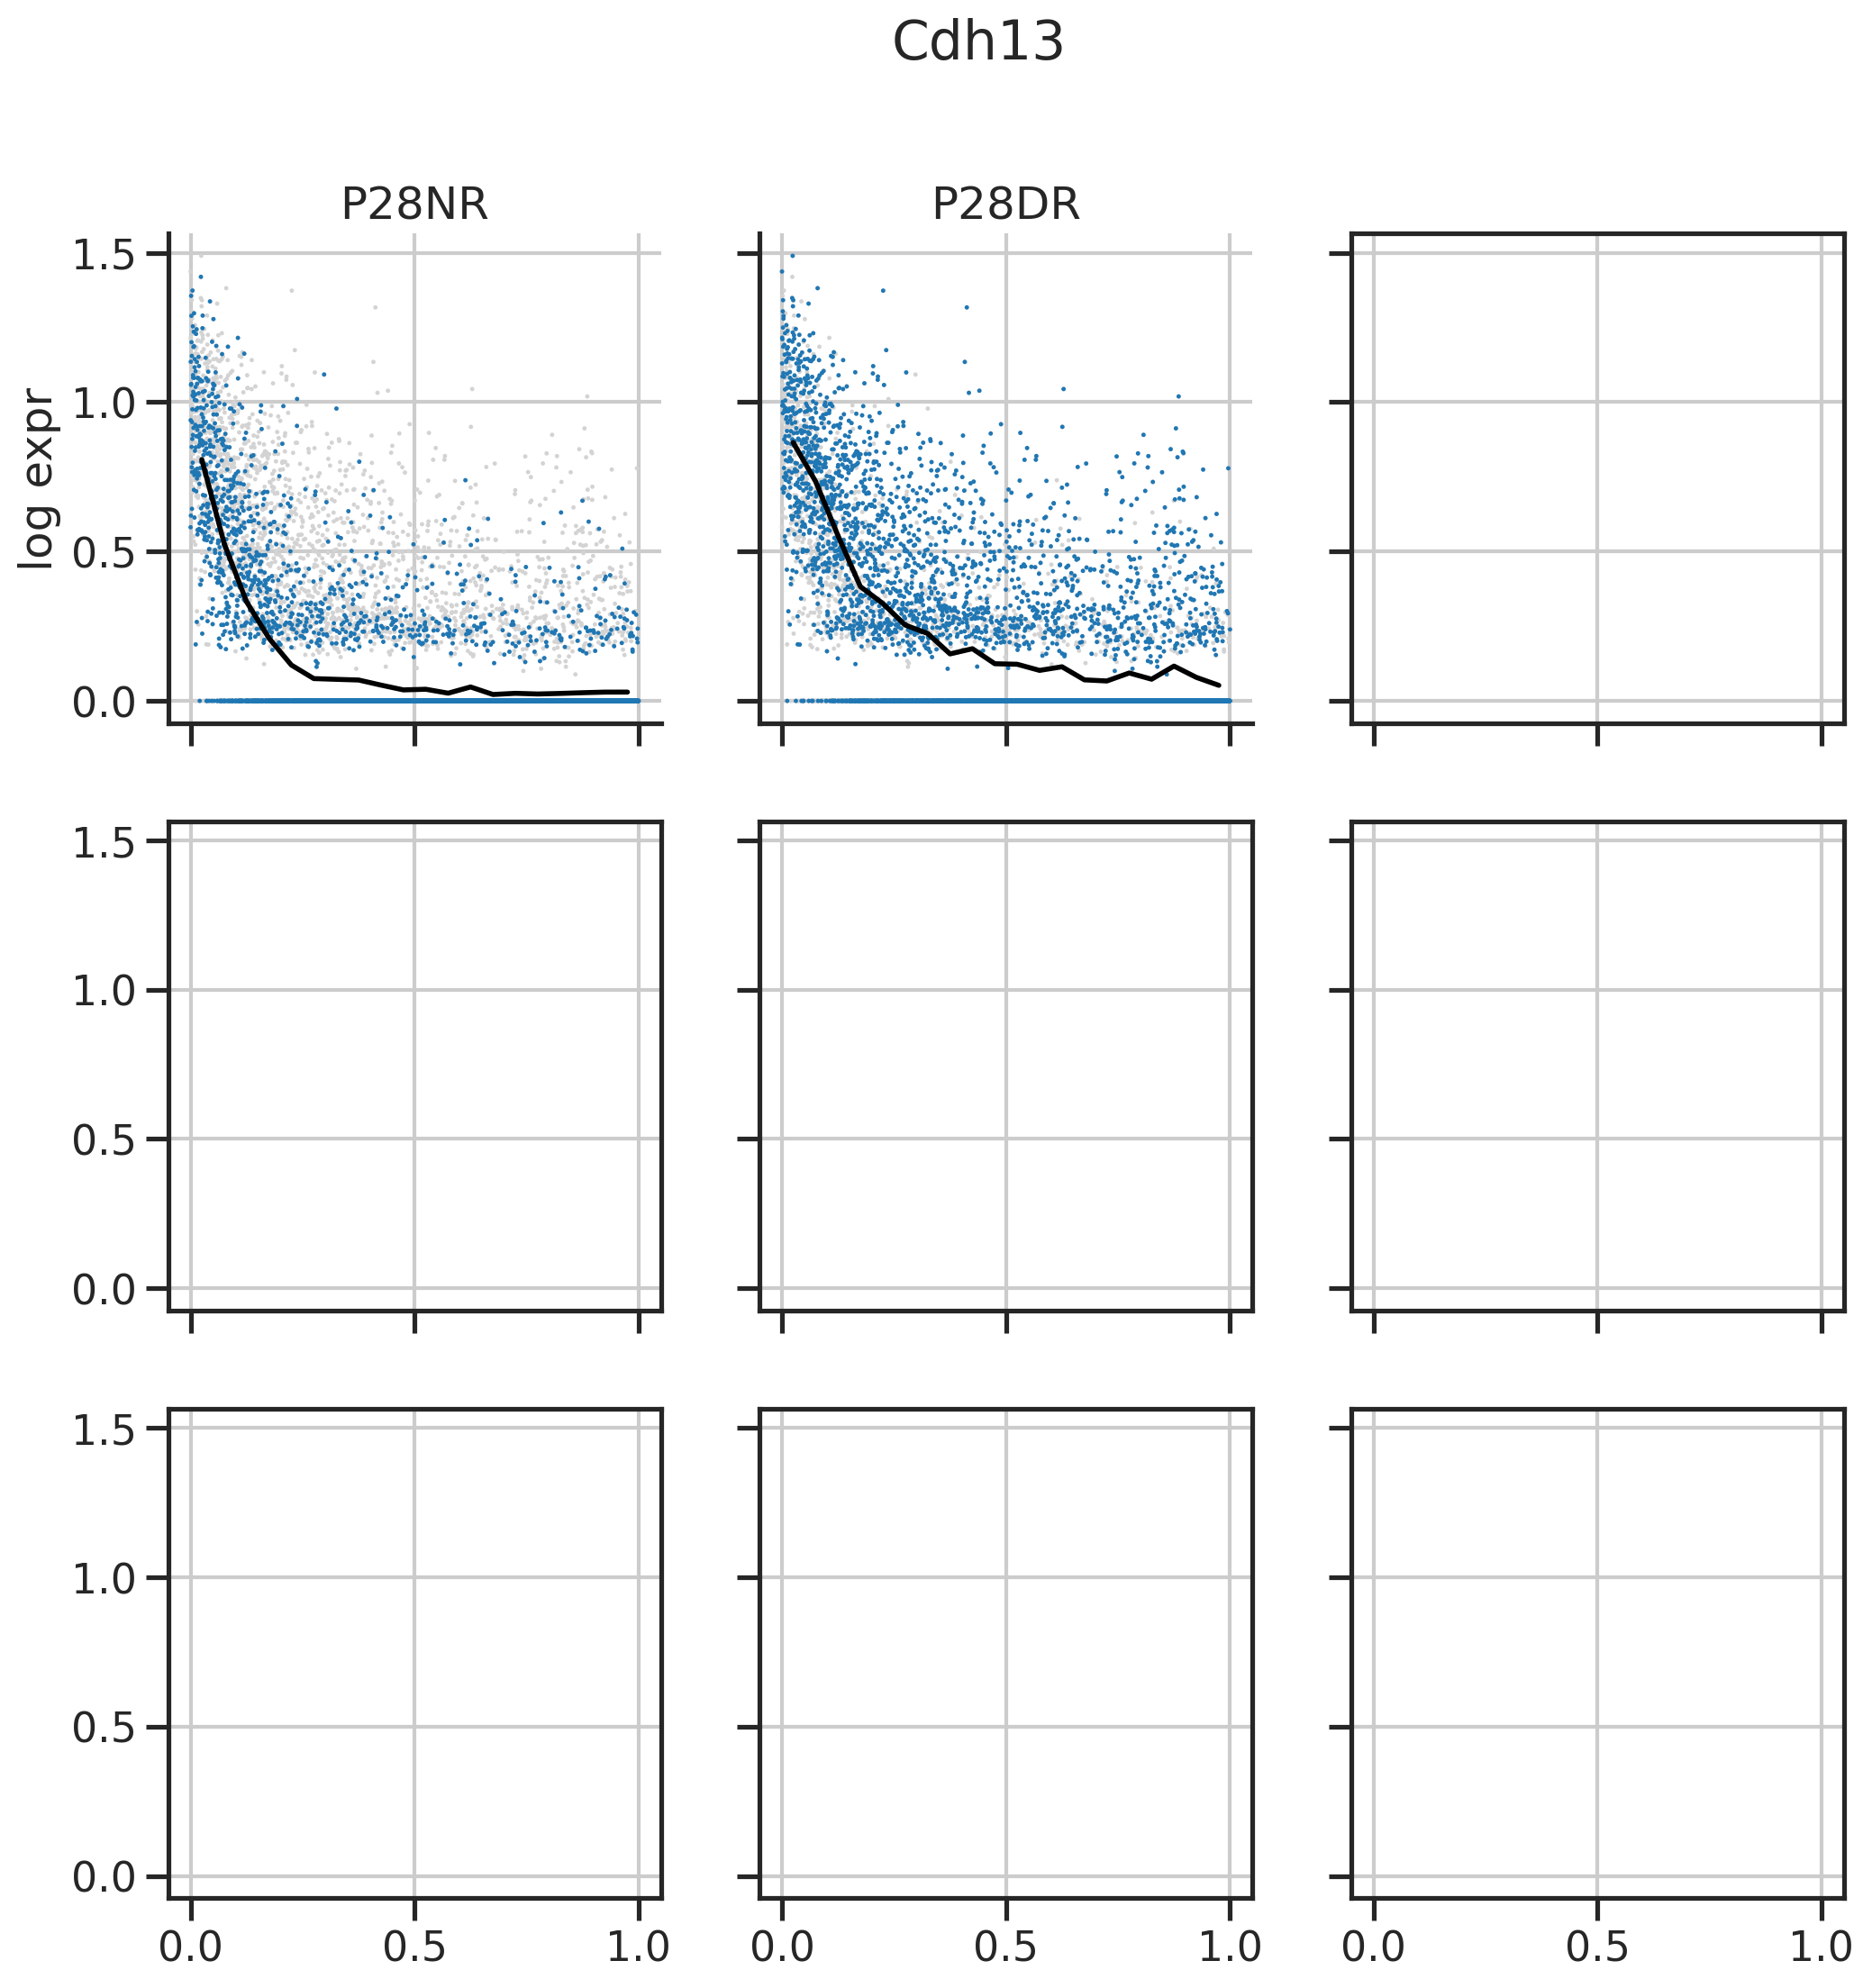

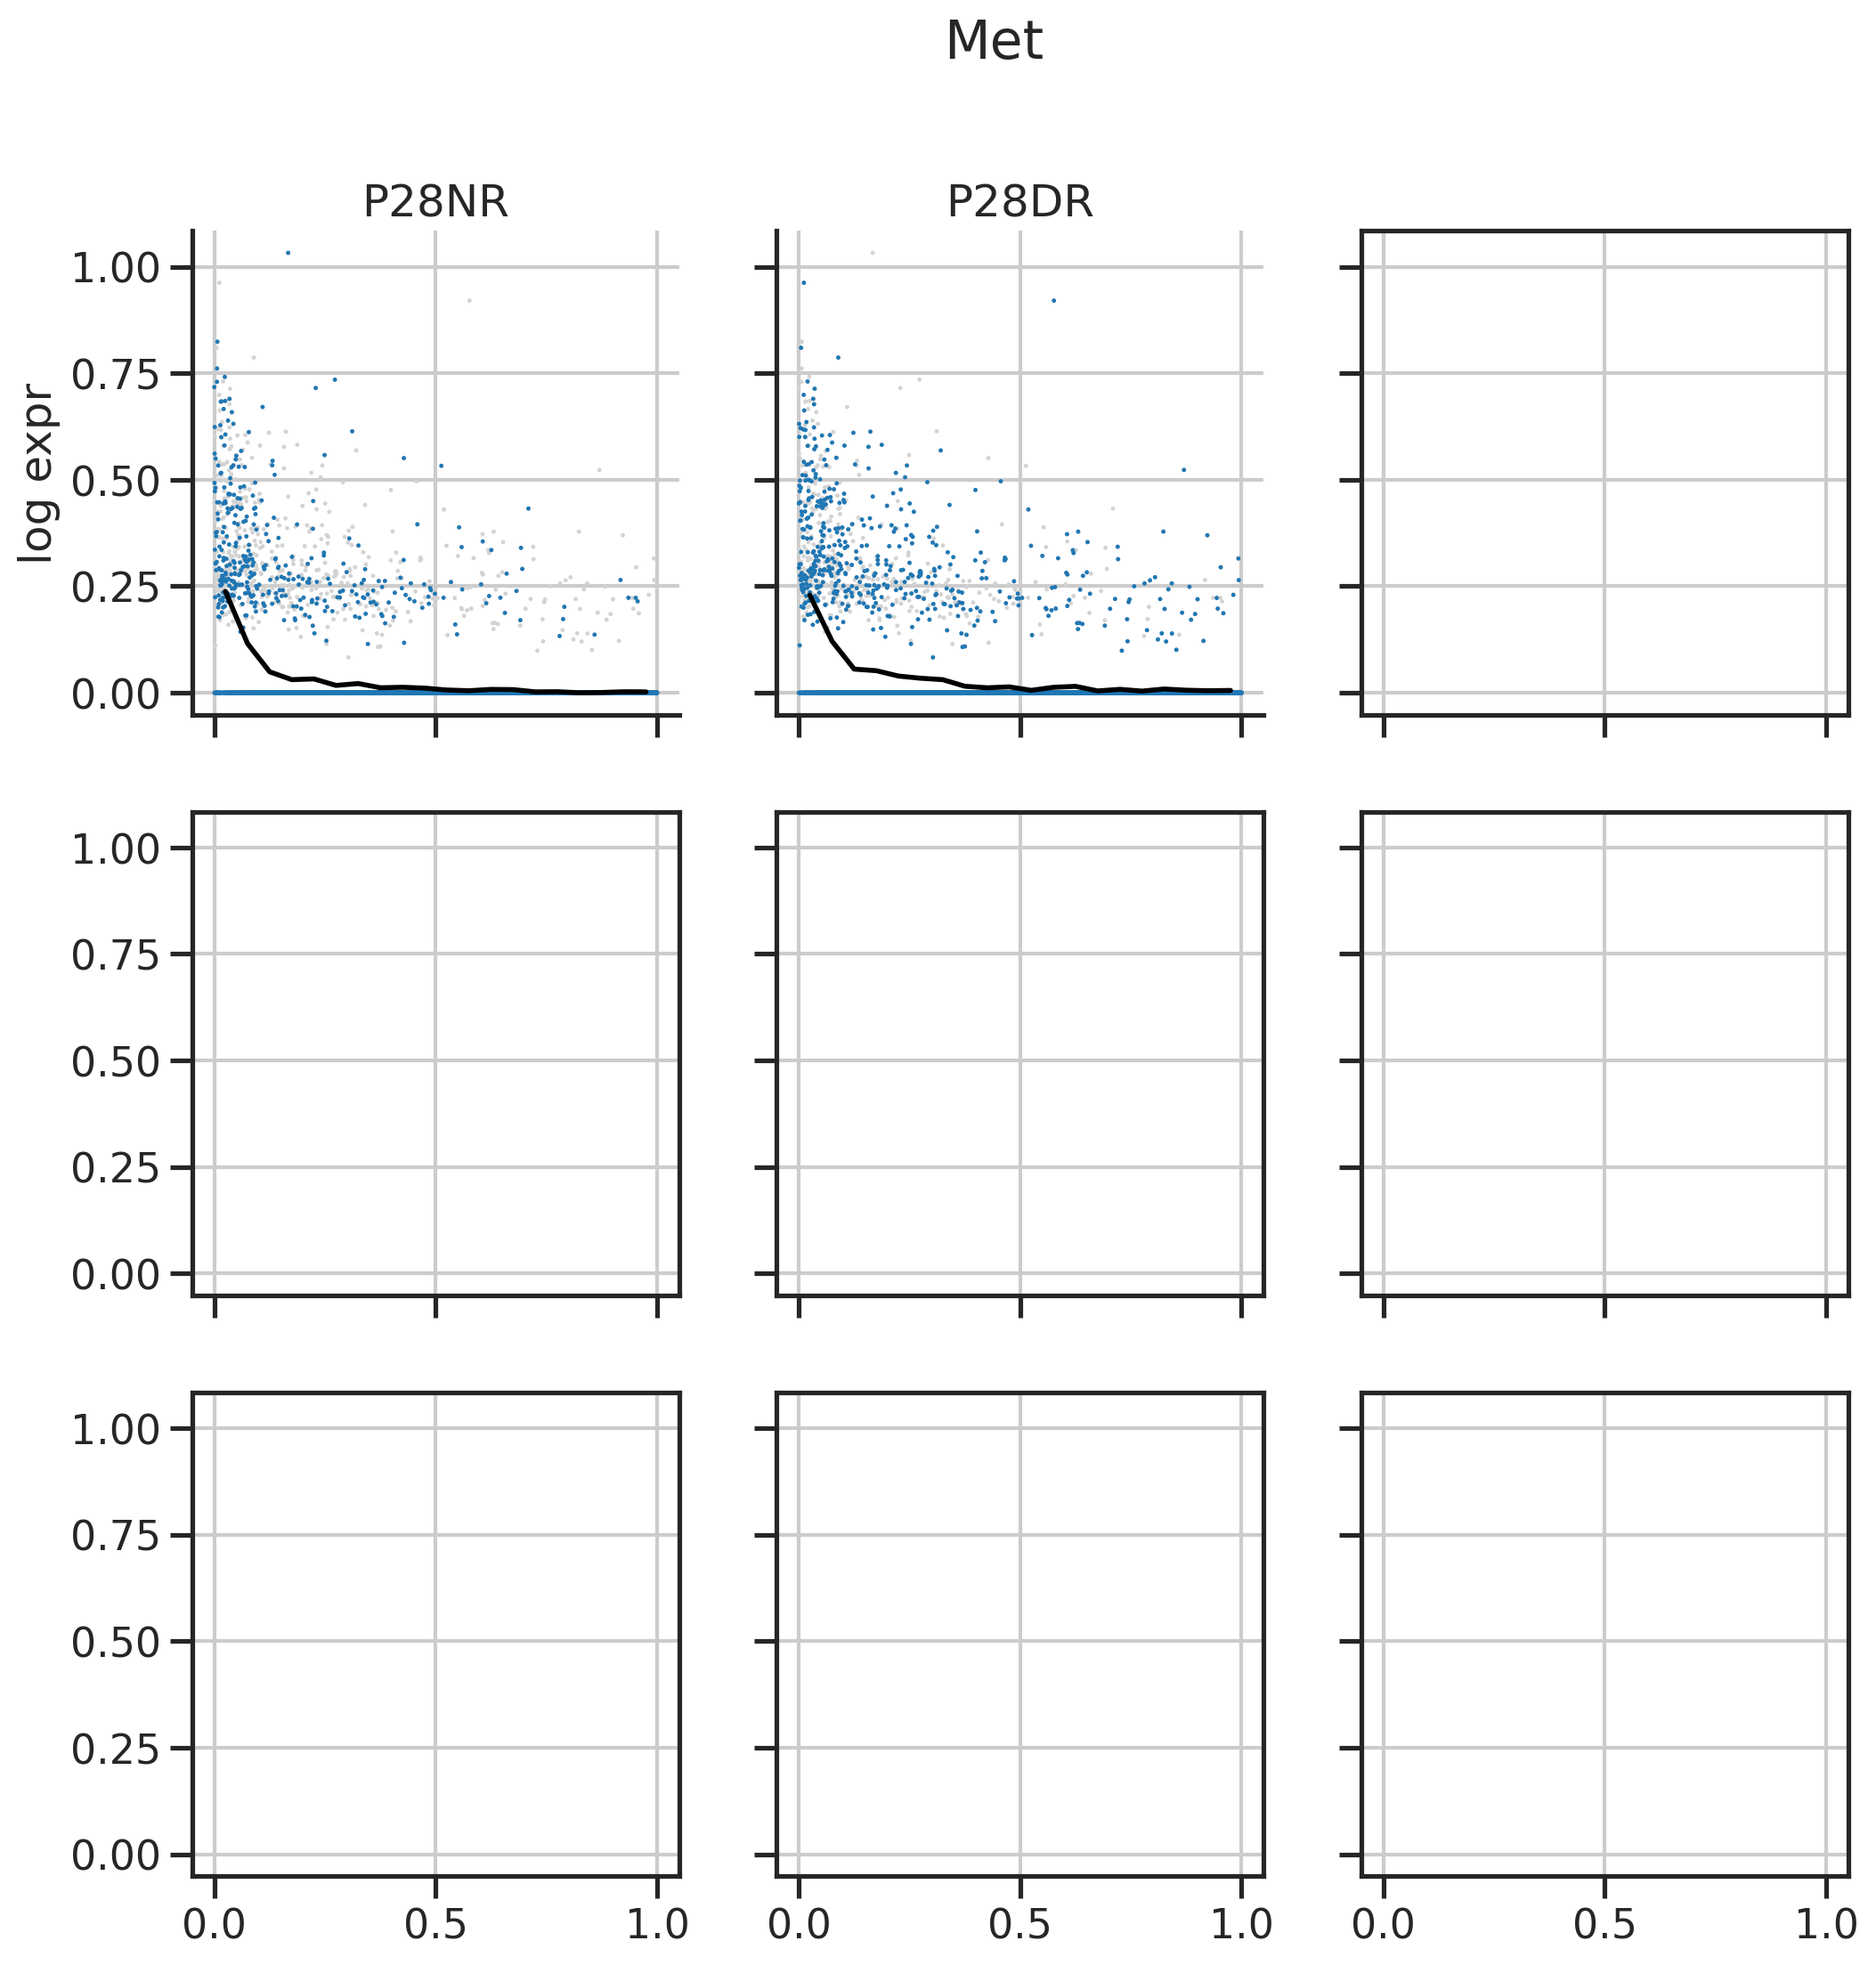

In [46]:

genes_toplot = ['Cdh13', 'Met']
for gene_toplot in genes_toplot:
    gi3 = basicu.get_index_from_array(allgenes, [gene_toplot])

    # a big table of everything
    allcells = adata.obs.index.values
    bigmat = []
    bigtypes = []
    bigsamps = []
    ncases = []

    resdict = {}
    for case in cases:
        # select cells
        adata_sub = adata[adata.obs['cond']==case]
        cells_sub = adata_sub.obs.index.values
        cellsidx_sub = basicu.get_index_from_array(allcells, cells_sub)

        dfall_sub = dfall.loc[cells_sub]

        ftrs_sub  = adata_raw[cells_sub].X
        cov = np.ravel(ftrs_sub.sum(axis=1))
        ftrs_sub  = np.log10(np.asarray(ftrs_sub[:,gi3].todense())/cov.reshape(-1,1)*1e4+1)

        # order cells
        types   = adata_sub.obs['easitype'].values
        samps   = adata_sub.obs['easisamp'].values
        cellidx = np.argsort(dfall_sub['ptime'].values)
        resdict[case] = ftrs_sub[cellidx]

    fig, axs = plt.subplots(3,3,figsize=(4*3,4*3),sharex=True, sharey=True)
    for i, (ax, case) in enumerate(zip(axs.flat, cases)):
        for _case in cases:
            a = resdict[_case]
            ax.scatter(np.linspace(0, 1, len(a)), a, s=3, edgecolor='none', color='lightgray')

        a = resdict[case]
        ax.scatter(np.linspace(0, 1, len(a)), a, s=3, edgecolor='none', label=case)
        _df = pd.DataFrame()
        _df['x'] = np.linspace(0, 1, len(a))
        _df['y'] = a[:,0]
        _df['xbin'] = pd.cut(_df['x'], 20)
        _df = _df.groupby('xbin').mean()
        ax.plot(_df['x'], _df['y'], label=case, color='k', linewidth=2)

        ax.set_title(case)
        sns.despine(ax=ax)

        if i % 3 == 0: 
            ax.set_ylabel('log expr')
        if i // 3 == 2:
            ax.set_xlabel('L2/3 grad ranking')
    fig.suptitle(gene_toplot)

# Each gene how much
- compare the average expr across 20 bins
- record total abs diff for each gene
- plot and check those that have changed vs not changed.